# **Set Up**

In [ ]:
# suggested imports

import pandas as pd
from nltk.tag import pos_tag
import re
from collections import defaultdict,Counter
from nltk.stem import WordNetLemmatizer
from datetime import datetime
from tqdm import tqdm
import numpy as np
import os
tqdm.pandas()
from ast import literal_eval
# nltk imports, note that these outputs may be different if you are using colab or local jupyter notebooks
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords as sw
import string
from nltk.corpus import wordnet as wn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
import itertools 
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from psutil import *

# CPU Specification
!lscpu |grep 'Model name'
print('CPU Core Count:',cpu_count())

# GPU Specification
!nvidia-smi -L

# System Memory
!free -h --si | awk '/Mem:/{print $2}'

# System Storage Memory
!df -h / |awk '{print $4}'

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz
CPU Core Count: 4
GPU 0: Tesla T4 (UUID: GPU-dceb54d5-8c0f-7295-1bfc-08c01aef6042)
26G
Avail
144G


# **Data Import**

In [ ]:
# Code Added By Akshay - 15 Apr 2023
# To Fetch CSV File On Drive
!gdown --id 1tWGpElxe-GRd3NE7F_3XJ_4-V78gYuB9

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1tWGpElxe-GRd3NE7F_3XJ_4-V78gYuB9
To: /content/opinion_fact_news.csv
100% 29.7M/29.7M [00:00<00:00, 44.0MB/s]


In [ ]:
data = pd.read_csv("opinion_fact_news.csv")

In [ ]:
data.isnull().sum()

title    0
body     0
label    0
dtype: int64

# **Pre-Processing** 

In [ ]:
sw1 = sw.words('english')
p = list(string.punctuation)
english_stopwords = sw1+p

In [ ]:
def get_wordnet_pos(word):
    if word.startswith('N'):
        return wn.NOUN
    elif word.startswith('V'):
        return wn.VERB
    elif word.startswith('J'):
        return wn.ADJ
    elif word.startswith('R'):
        return wn.ADV
    else:
        return wn.NOUN
    
def preprocess(text):
    lemmatizer = nltk.WordNetLemmatizer().lemmatize
    text = re.sub('\W+', ' ', str(text))
    text = re.sub(r'[0-9]+', '', text.lower())
    word_pos = nltk.pos_tag(nltk.word_tokenize(text))
    normalized_text_lst = [lemmatizer(x[0], get_wordnet_pos(x[1])).lower() for x in word_pos]
    stop_words_free = [i for i in normalized_text_lst if i not in english_stopwords and len(i) > 3]
    stop_words_free = list(set(stop_words_free))
    return(stop_words_free)

In [ ]:
data['full_text'] = data['title'] +'. '+data['body']

In [ ]:
# Start Timer
import time
start_time = time.time()

data['full_text_cleaned'] = data['full_text'].apply(preprocess)

# Count Time Timer
print('\n','Processing Time: ', (time.time()-start_time))
del start_time


 Processing Time:  235.78143334388733


In [ ]:
data["label"].value_counts()

opinion    5000
fact       5000
Name: label, dtype: int64

In [ ]:
data_tfidf = data.copy()
data_tfidf = data_tfidf[['label','full_text','full_text_cleaned']]
data_tfidf.head()

label                                          full_text  \
0  opinion  Is Bernie Sanders really happening?. Watching ...   
1  opinion  The London terror attack would’ve been much wo...   
2  opinion  The Super Bowl poses the question: What’s more...   
3  opinion  On health care, is Trump malicious or just inc...   
4  opinion  What ever happened to that ‘head on a pike’ st...   

                                   full_text_cleaned  
0  [biter, purse, tammy, abnormal, water, doubly,...  
1  [count, lethal, suicide, kill, include, change...  
2  [huge, career, play, count, screen, beauty, ma...  
3  [falsely, service, ignorance, policy, meeting,...  
4  [atmosphere, white, believe, schiff, house, di...

In [ ]:
data_tfidf['full_text_cleaned'] = data_tfidf['full_text_cleaned'].apply(lambda x: ' '.join(x))

In [ ]:
data_tfidf.head()

label                                          full_text  \
0  opinion  Is Bernie Sanders really happening?. Watching ...   
1  opinion  The London terror attack would’ve been much wo...   
2  opinion  The Super Bowl poses the question: What’s more...   
3  opinion  On health care, is Trump malicious or just inc...   
4  opinion  What ever happened to that ‘head on a pike’ st...   

                                   full_text_cleaned  
0  biter purse tammy abnormal water doubly throat...  
1  count lethal suicide kill include change vest ...  
2  huge career play count screen beauty malfuncti...  
3  falsely service ignorance policy meeting profe...  
4  atmosphere white believe schiff house directly...

# **EDA**

## **Statistics**

In [ ]:
data.describe()

title  \
count                                               10000   
unique                                               8248   
top     Factbox: Latest on the coronavirus spreading i...   
freq                                                   16   

                                                     body    label  \
count                                               10000    10000   
unique                                               9892        2   
top     Here’s what you need to know to understand wha...  opinion   
freq                                                    3     5000   

                                                full_text  \
count                                               10000   
unique                                              10000   
top     Is Bernie Sanders really happening?. Watching ...   
freq                                                    1   

                                        full_text_cleaned  
count                                               10000  
unique                                               9918  
top     [photo, excessive, agreement, sense, importanc...  
freq                                                    2

In [ ]:
print(f'Number of unique values in title = {data["title"].nunique()}')
print(f'Number of unique values in body = {data["body"].nunique()}')

Number of unique values in title = 8248
Number of unique values in body = 9892


In [ ]:
df = data
class_df = df.groupby('label').count()['title'].reset_index().sort_values(by='title',ascending=False)
class_df.style.background_gradient(cmap='winter')

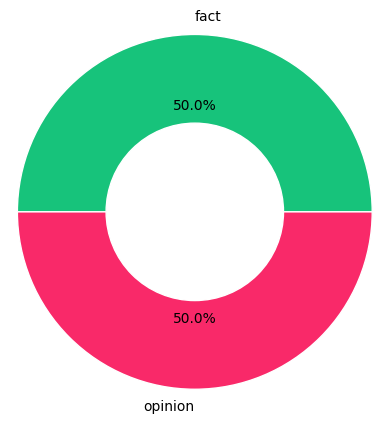

In [ ]:
# Graph Information:
# ------------------
# Type: Pie chart
# Title: Pie chart of news stories classified as opinons or facts
# Color (HEX): '#17C37B','#F92969','#FACA0C'

# Graph Description:
# ------------------
# This pie chart illustrates the proportion of opinion and factual news stories in the dataset.

# Data Information:
# -----------------
# The dataset used for this graph contains a column named "label" which states whether the news story is an opinion or fact.

# Note:
# -----
# The pie chart assumes that the "label" column contains categorical data.

# Code Output:
# ------------
# The output of this code is a pie chart that displays the proportion of the "label" column.

# What is the distribution of the opinions and facts in the dataset?
# --------------------------------
# graph shows 50 - 50 distribution of opinions and facts in the dataset.
percent_class=class_df.title
labels= class_df.label

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

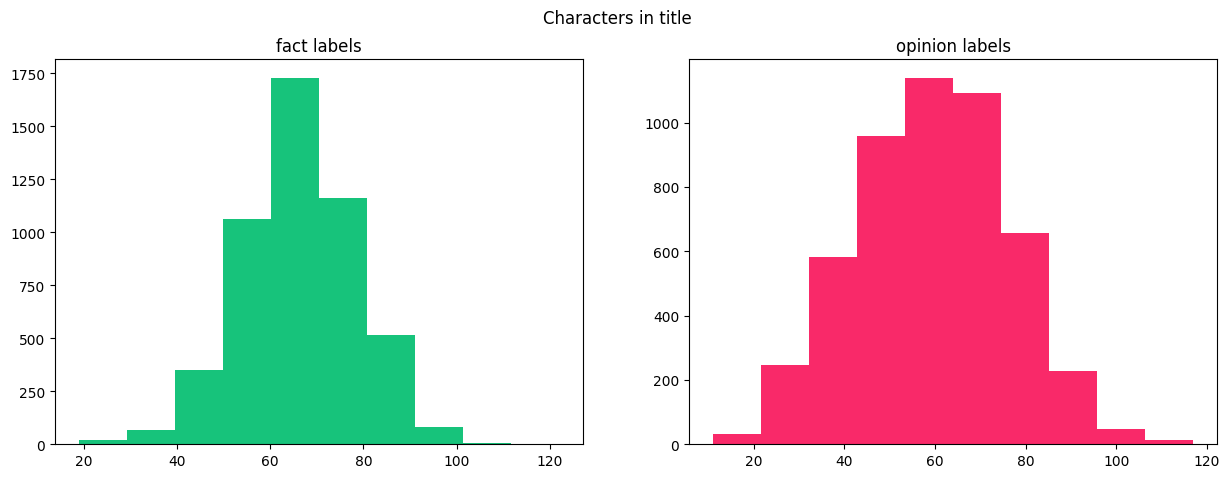

In [ ]:
# Graph Information:
# ------------------
# Type: Histogram
# Title: Histograms of character length in title in both opinion and factual news stories 
# Color (HEX): '#17C37B','#F92969'

# Graph Description:
# ------------------
# These histograms illustrate the character length in the title of both opinion and factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a variable called news_len which counts the number of characters in title.

# Note:
# -----
# The histograms assume that the news_len variable contains numerical data.

# Code Output:
# ------------
# The output of this code are histograms for character length in the title of both opinion and factual news stories.

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

news_len=df[df['label']=="fact"]['title'].str.len()
ax1.hist(news_len,color='#17C37B')
ax1.set_title('fact labels')

news_len=df[df['label']=="opinion"]['title'].str.len()
ax2.hist(news_len,color='#F92969')
ax2.set_title('opinion labels')

fig.suptitle('Characters in title')
plt.show()

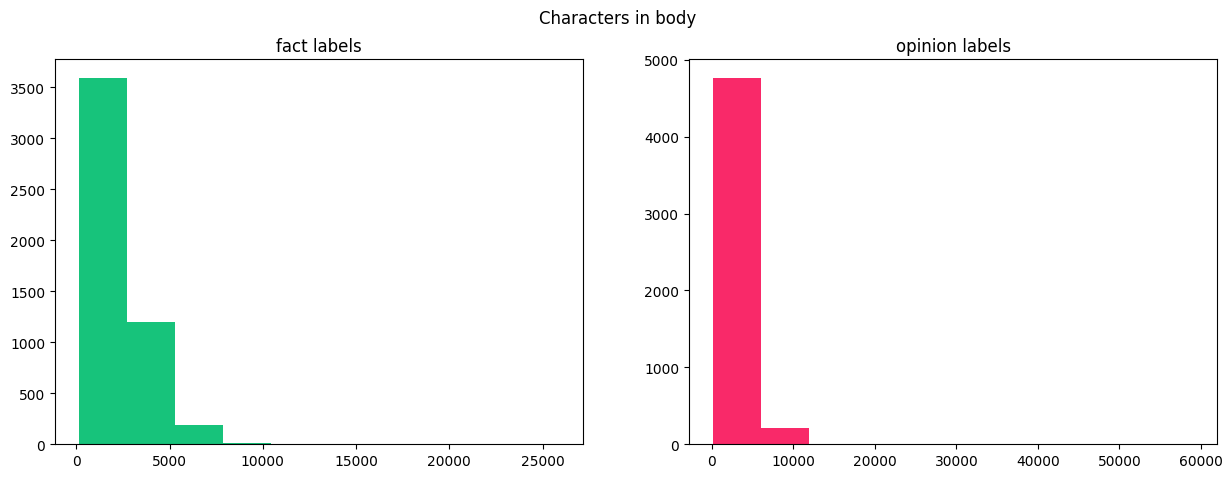

In [ ]:
# Graph Information:
# ------------------
# Type: Histogram
# Title: Histograms of character length in body in both opinion and factual news stories 
# Color (HEX): '#17C37B','#F92969'

# Graph Description:
# ------------------
# These histograms illustrate the character length in the body of both opinion and factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a variable called news_len which counts the number of characters in body.

# Note:
# -----
# The histograms assume that the news_len variable contains numerical data.

# Code Output:
# ------------
# The output of this code are histograms for character length in the body of both opinion and factual news stories.

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

news_len=df[df['label']=="fact"]['body'].str.len()
ax1.hist(news_len,color='#17C37B')
ax1.set_title('fact labels')

news_len=df[df['label']=="opinion"]['body'].str.len()
ax2.hist(news_len,color='#F92969')
ax2.set_title('opinion labels')

fig.suptitle('Characters in body')
plt.show()

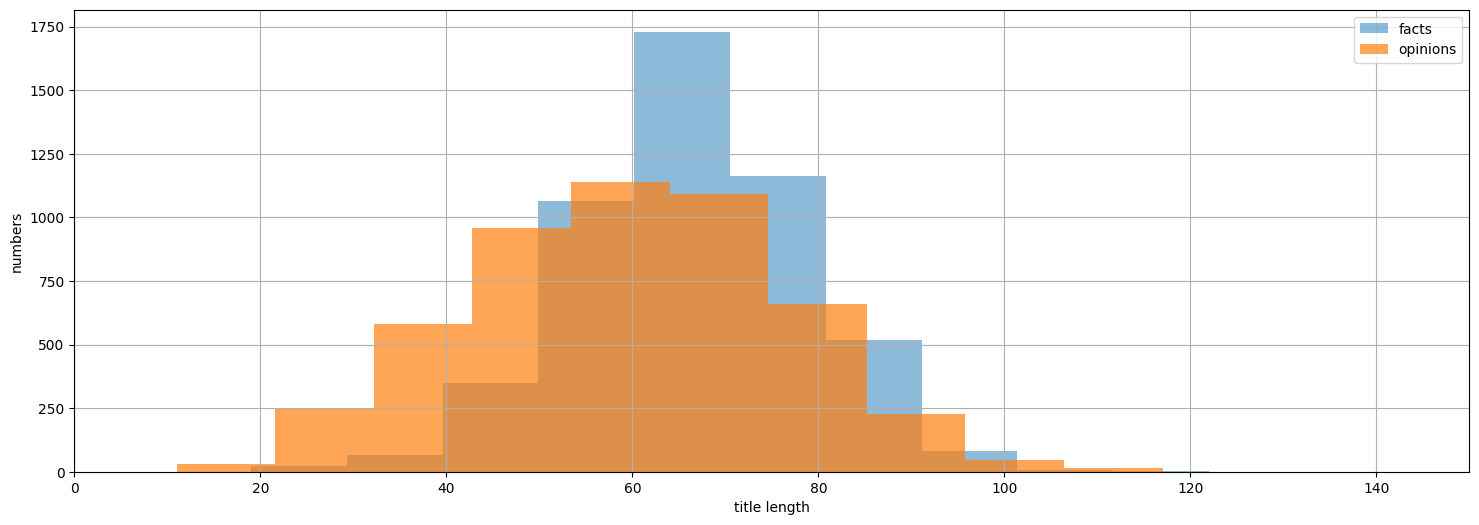

In [ ]:
# Graph Information:
# ------------------
# Type: Overlapping histogram
# Title: Overlapping histograms of character length in title in both opinion and factual news stories 
# Color (HEX): '#17C37B','#F92969'

# Graph Description:
# ------------------
# These overlapping histograms illustrate the character length in the title of both opinion and factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a column called length_title which counts the number of characters in title.

# Note:
# -----
# The overlapping histograms assume that the length_title column contains numerical data.

# Code Output:
# ------------
# The output of this code are overlapping histograms for character length in the title of both opinion and factual news stories.
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
df['length_title'] = df.title.apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(df[df['label'] == "fact"]['length_title'], alpha = 0.5, bins=bins, label='facts')
plt.hist(df[df['label'] == "opinion"]['length_title'], alpha = 0.7, bins=bins, label='opinions')
plt.xlabel('title length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

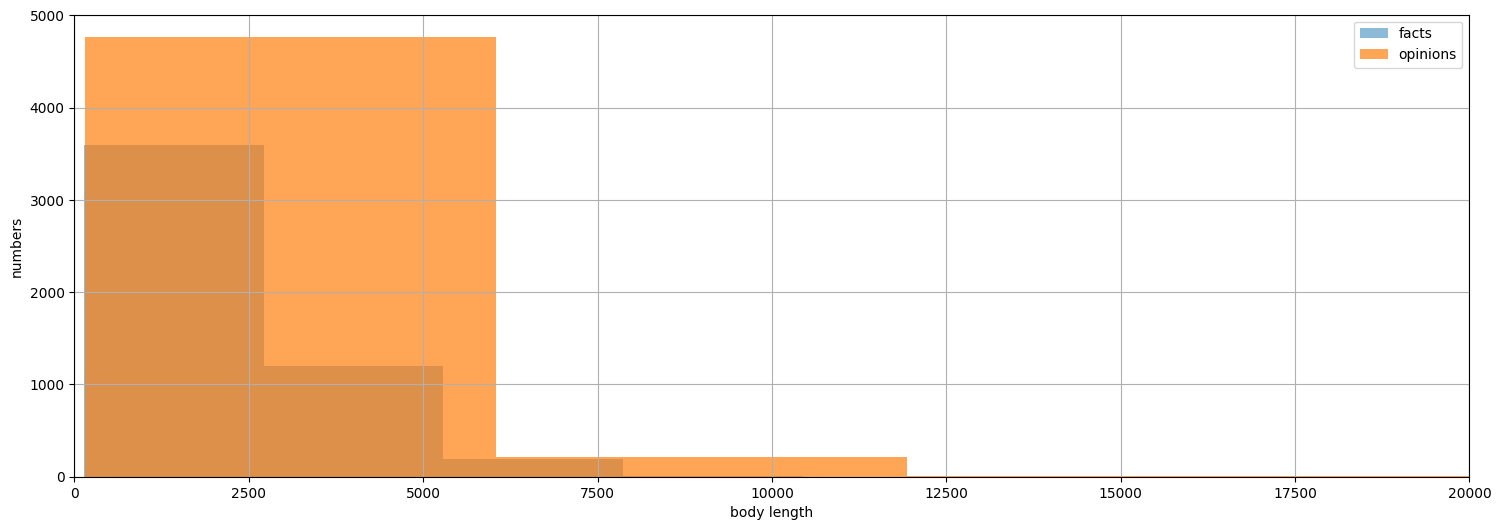

In [ ]:
# Graph Information:
# ------------------
# Type: Overlapping histogram
# Title: Overlapping histograms of character length in body in both opinion and factual news stories 
# Color (HEX): '#17C37B','#F92969'

# Graph Description:
# ------------------
# These overlapping histograms illustrate the character length in the body of both opinion and factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a column called length_body which counts the number of characters in body.

# Note:
# -----
# The overlapping histograms assume that the length_body column contains numerical data.

# Code Output:
# ------------
# The output of this code are overlapping histograms for character length in the body of both opinion and factual news stories.
df['length_body'] = df.body.apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 10
plt.hist(df[df['label'] == "fact"]['length_body'], alpha = 0.5, bins=bins, label='facts')
plt.hist(df[df['label'] == "opinion"]['length_body'], alpha = 0.7, bins=bins, label='opinions')
plt.xlabel('body length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,20000)
plt.grid()
plt.show()

<ipython-input-23-3be6ded5e291>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
<ipython-input-23-3be6ded5e291>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')


Text(0.5, 0.98, 'Average word length in each news title')

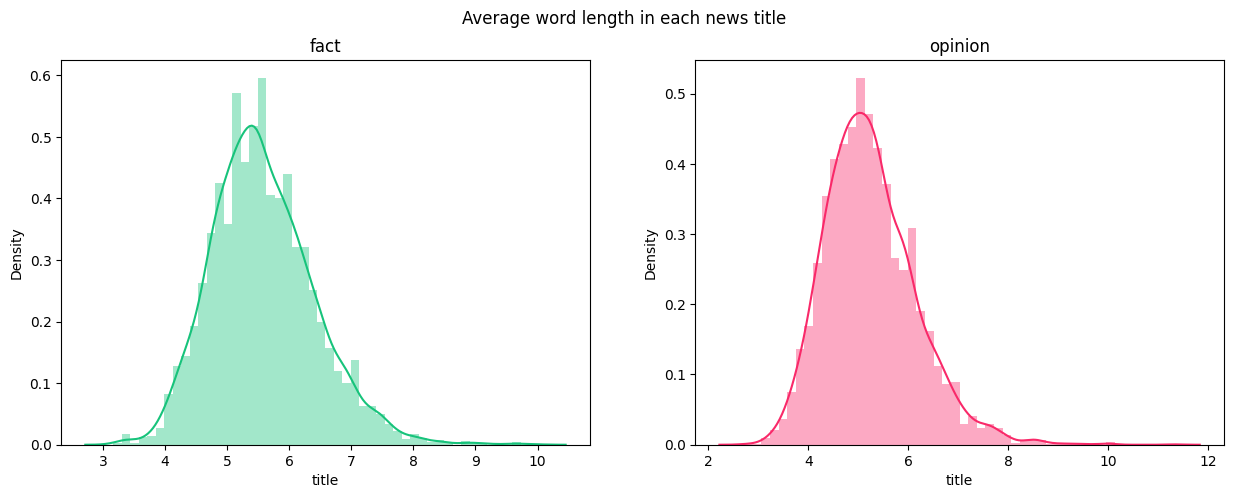

In [ ]:
# Graph Information:
# ------------------
# Type: Distribution plot
# Title: Distribution plots of average words length in title in both opinion and factual news stories 
# Color (HEX): '#17C37B','#F92969'

# Graph Description:
# ------------------
# These distribution plots illustrate the average words length in the title of both opinion and factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a column called word which counts the number of characters in title.

# Note:
# -----
# The distribution plots assume that the word column contains numerical data.

# Code Output:
# ------------
# The output of this code are distribution plots for average words length in the title of both opinion and factual news stories.
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

word=df[df['label']=="fact"]['title'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('fact')


word=df[df['label']=="opinion"]['title'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('opinion')

fig.suptitle('Average word length in each news title')

<ipython-input-24-7c088351a5d5>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
<ipython-input-24-7c088351a5d5>:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')


Text(0.5, 0.98, 'Average word length in each news body')

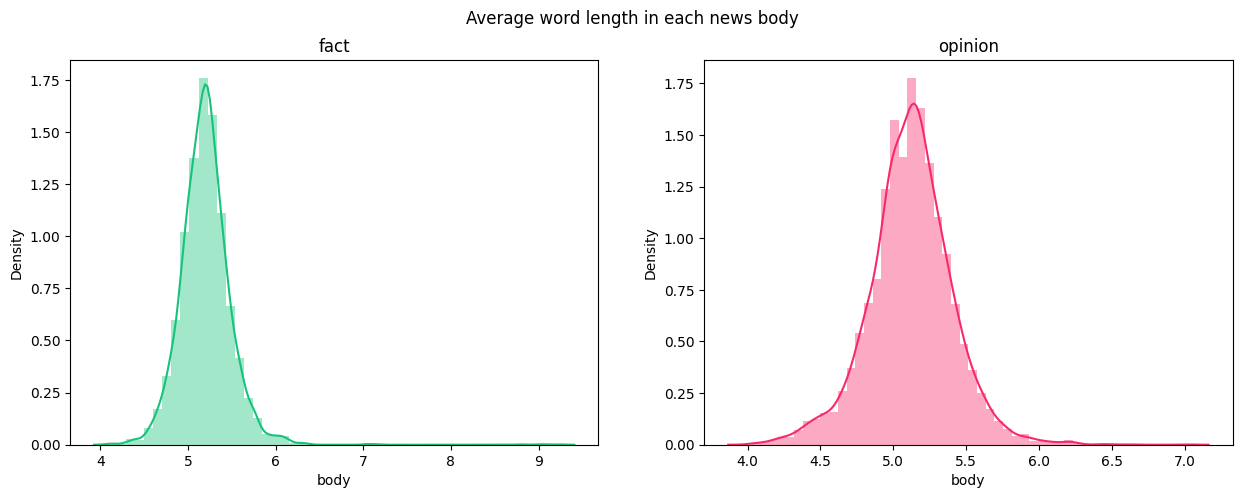

In [ ]:
# Graph Information:
# ------------------
# Type: Distribution plot
# Title: Distribution plots of average words length in body in both opinion and factual news stories 
# Color (HEX): '#17C37B','#F92969'

# Graph Description:
# ------------------
# These distribution plots illustrate the average words length in the body of both opinion and factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a column called word which counts the number of characters in body.

# Note:
# -----
# The distribution plots assume that the word column contains numerical data.

# Code Output:
# ------------
# The output of this code are distribution plots for average words length in the body of both opinion and factual news stories.
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

word=df[df['label']=="fact"]['body'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('fact')


word=df[df['label']=="opinion"]['body'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('opinion')

fig.suptitle('Average word length in each news body')

In [ ]:
def create_corpus_title(target):
    corpus_title=[]
    
    for x in df[df['label']==target ]['title'].str.split():
        for i in x:
            corpus_title.append(i)
    return corpus_title

def create_corpus_body(target):
    corpus_body =[]

    for x in df[df['label']==target ]['body'].str.split():
        for i in x:
            corpus_body.append(i)
    return corpus_body

<BarContainer object of 10 artists>

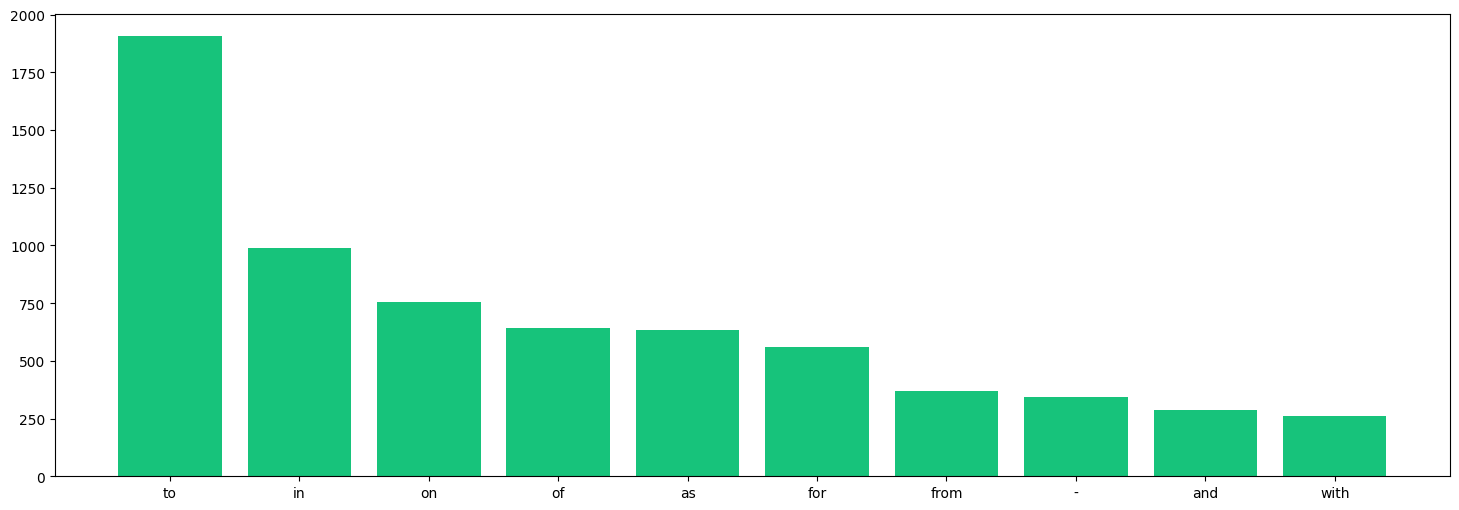

In [ ]:
# Graph Information:
# ------------------
# Type: Bar chart
# Title: Bar chart of common stopwords in title of factual news stories 
# Color (HEX): '#17C37B'

# Graph Description:
# ------------------
# These bar chart illustrate the common stopwords in the title of factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a dictionary called word which counts the number of characters in title.

# Note:
# -----
# The bar chart assume that the word dictionary contains categorical data.

# Code Output:
# ------------
# The output of this code are bar chart for common stopwords in the title of factual news stories.
corpus=create_corpus_title("fact")

dic=defaultdict(int)

for word in corpus:
    #if word in stop:
    if word in english_stopwords:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

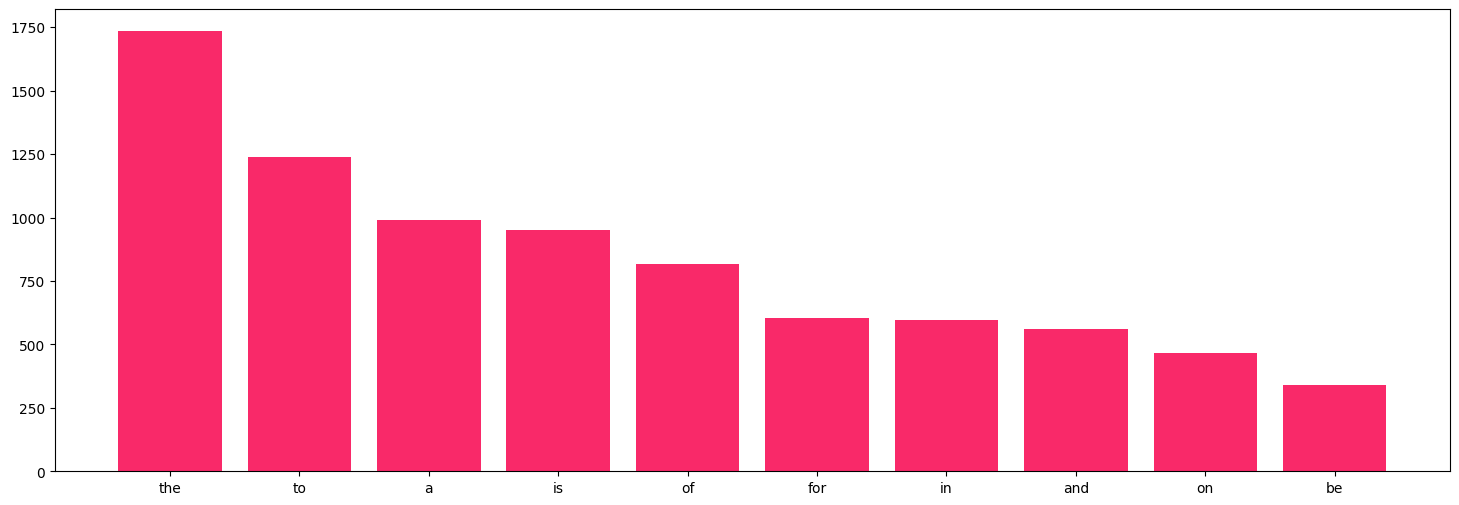

In [ ]:
# Graph Information:
# ------------------
# Type: Bar chart
# Title: Bar chart of common stopwords in title of opinion news stories 
# Color (HEX): '#F92969'

# Graph Description:
# ------------------
# These bar chart illustrate the common stopwords in the title of opinion news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a dictionary called word which counts the number of characters in title.

# Note:
# -----
# The bar chart assume that the word dictionary contains categorical data.

# Code Output:
# ------------
# The output of this code are bar chart for common stopwords in the title of opinion news stories.
corpus=create_corpus_title("opinion")

dic=defaultdict(int)
for word in corpus:
    #if word in stop:
    if word in english_stopwords:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

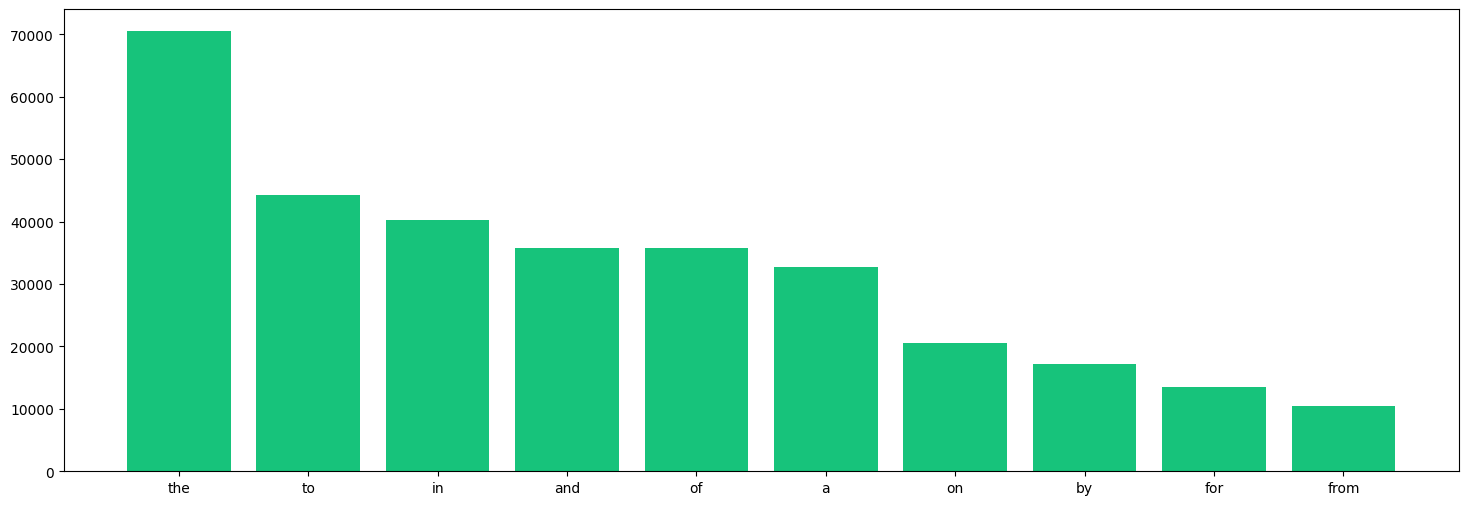

In [ ]:
# Graph Information:
# ------------------
# Type: Bar chart
# Title: Bar chart of common stopwords in body of factual news stories 
# Color (HEX): '#17C37B'

# Graph Description:
# ------------------
# These bar chart illustrate the common stopwords in the body of factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a dictionary called word which counts the number of characters in body.

# Note:
# -----
# The bar chart assume that the word dictionary contains categorical data.

# Code Output:
# ------------
# The output of this code are bar chart for common stopwords in the body of factual news stories.
corpus=create_corpus_body("fact")

dic=defaultdict(int)
for word in corpus:
    #if word in stop:
    if word in english_stopwords:    
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

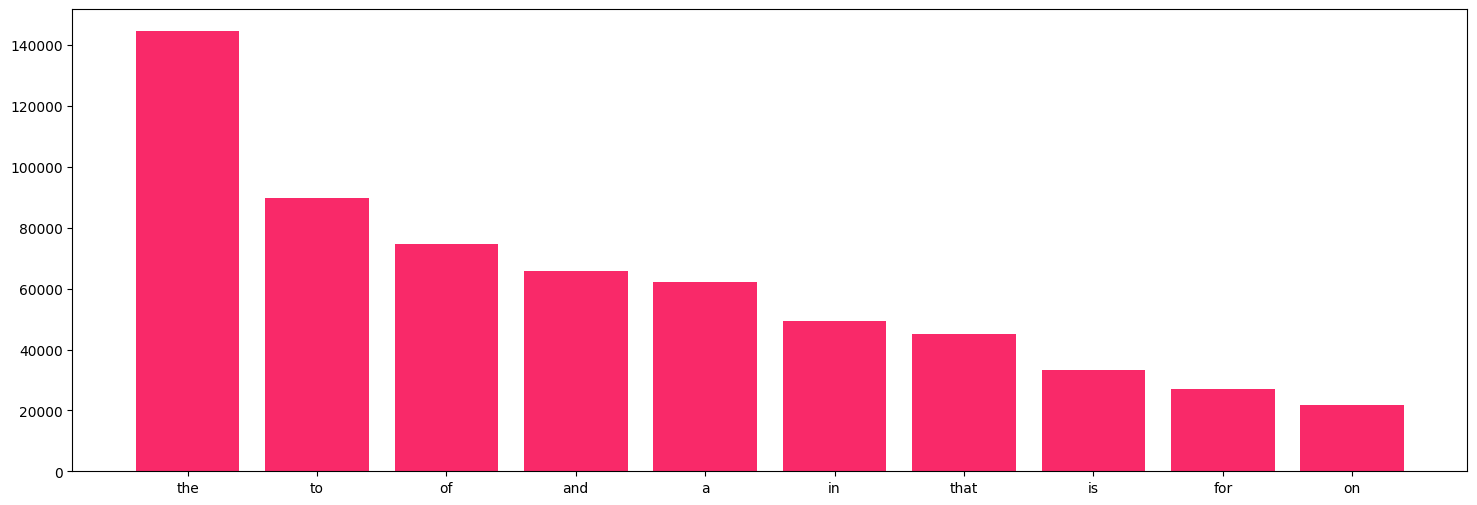

In [ ]:
# Graph Information:
# ------------------
# Type: Bar chart
# Title: Bar chart of common stopwords in body of opinion news stories 
# Color (HEX): '#F92969'

# Graph Description:
# ------------------
# These bar chart illustrate the common stopwords in the body of opinion news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a dictionary called word which counts the number of characters in body.

# Note:
# -----
# The bar chart assume that the word dictionary contains categorical data.

# Code Output:
# ------------
# The output of this code are bar chart for common stopwords in the body of opinion news stories.
corpus=create_corpus_body("opinion")

dic=defaultdict(int)
for word in corpus:
    if word in english_stopwords:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<Axes: >

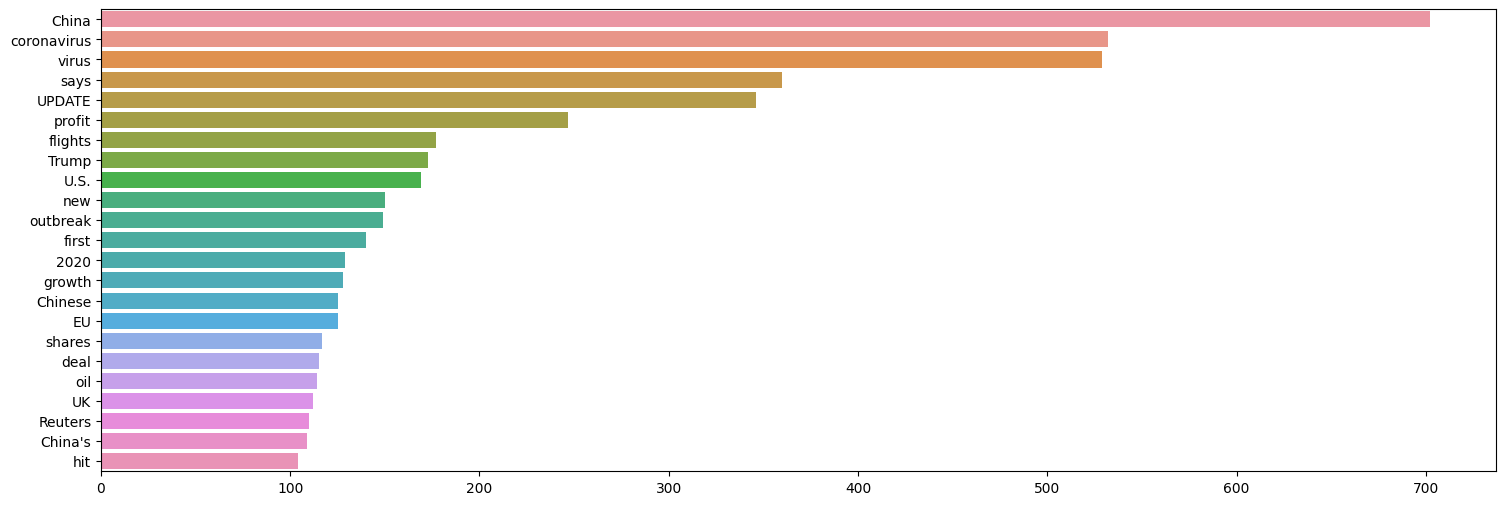

In [ ]:
# Graph Information:
# ------------------
# Type: Bar chart
# Title: Bar chart of common words in title of factual news stories 
# Color: default

# Graph Description:
# ------------------
# These bar chart illustrate the common words in the title of factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a two arrays; x = name of the common word, y = the number of times it appears in the dataset.

# Note:
# -----
# The bar chart assume that x contains categorical data and y contains numeric data.

# Code Output:
# ------------
# The output of this code are bar chart for common words in the title of factual news stories.
corpus=create_corpus_title("fact")

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in english_stopwords) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

<Axes: >

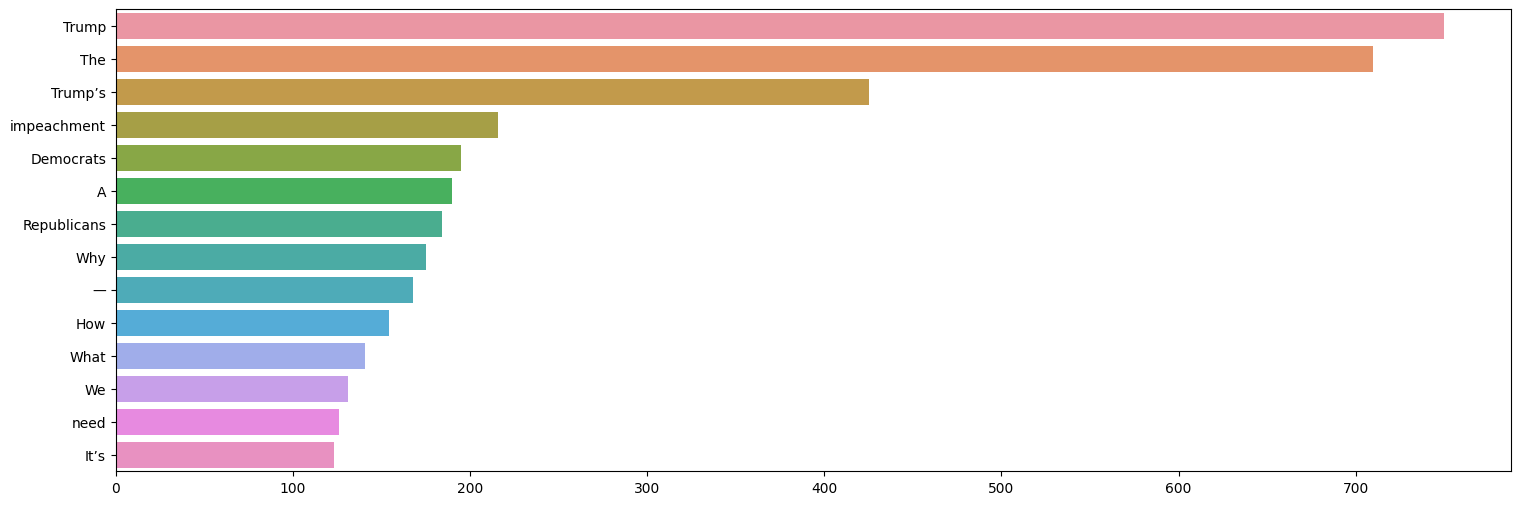

In [ ]:
# Graph Information:
# ------------------
# Type: Bar chart
# Title: Bar chart of common words in title of opinion news stories 
# Color: default

# Graph Description:
# ------------------
# These bar chart illustrate the common words in the title of opinion news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a two arrays; x = name of the common word, y = the number of times it appears in the dataset.

# Note:
# -----
# The bar chart assume that x contains categorical data and y contains numeric data.

# Code Output:
# ------------
# The output of this code are bar chart for common words in the title of opinion news stories.
corpus=create_corpus_title("opinion")

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in english_stopwords) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

<Axes: >

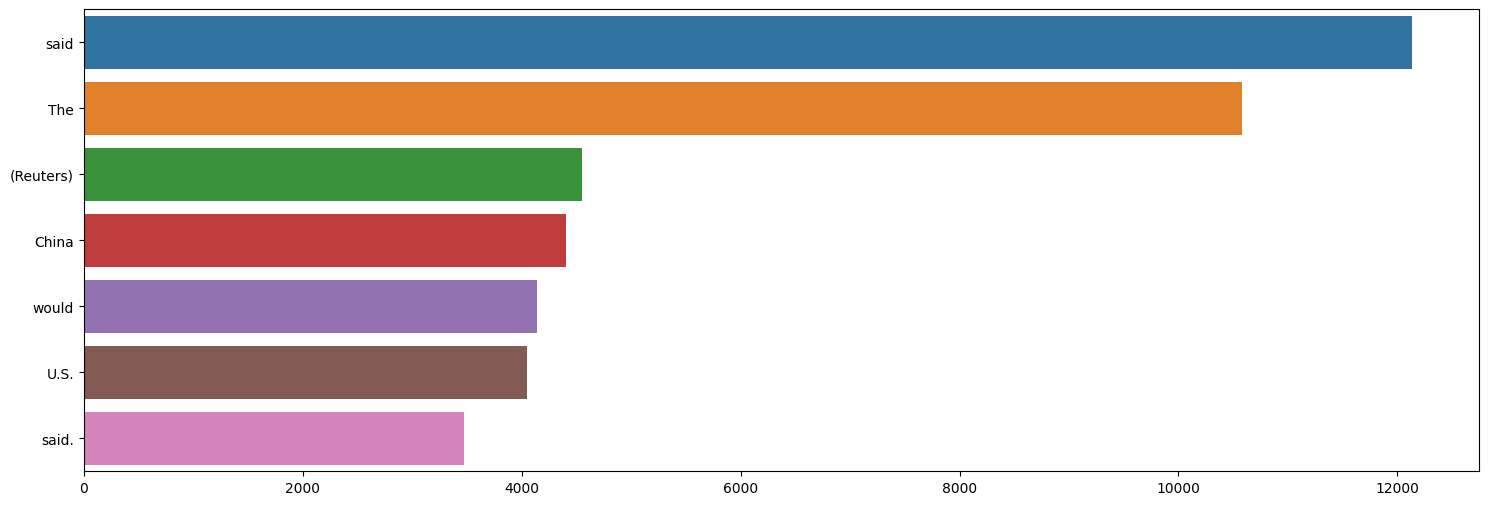

In [ ]:
# Graph Information:
# ------------------
# Type: Bar chart
# Title: Bar chart of common words in body of factual news stories 
# Color: default

# Graph Description:
# ------------------
# These bar chart illustrate the common words in the body of factual news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a two arrays; x = name of the common word, y = the number of times it appears in the dataset.

# Note:
# -----
# The bar chart assume that x contains categorical data and y contains numeric data.

# Code Output:
# ------------
# The output of this code are bar chart for common words in the body of factual news stories.
corpus=create_corpus_body("fact")

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in english_stopwords) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

<Axes: >

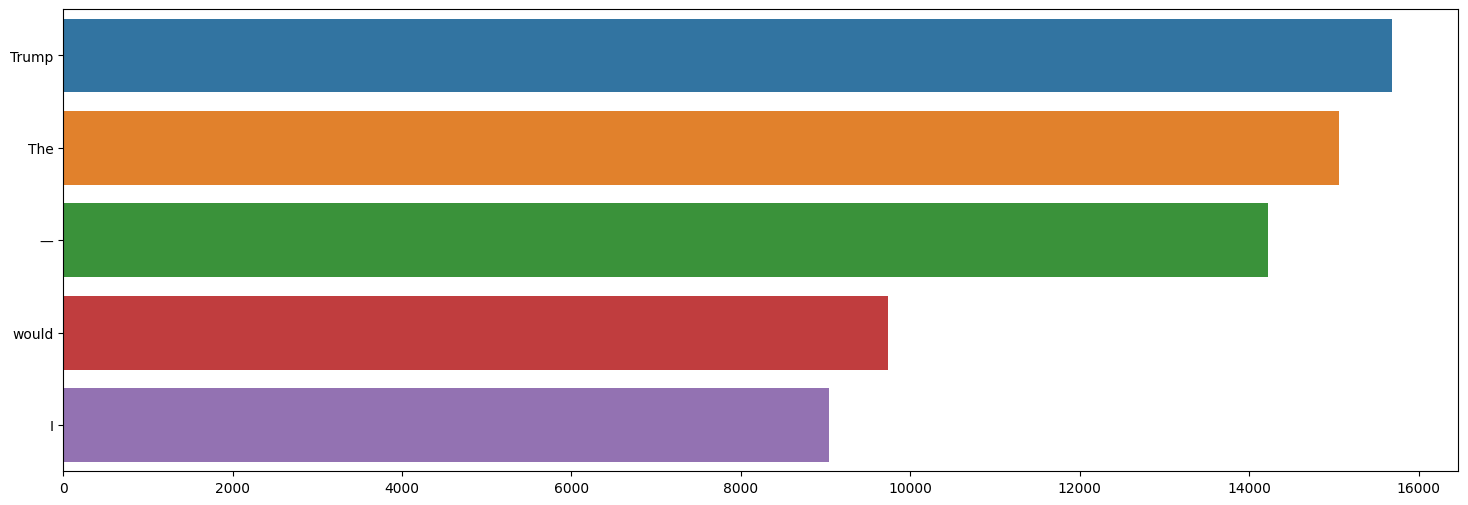

In [ ]:
# Graph Information:
# ------------------
# Type: Bar chart
# Title: Bar chart of common words in body of opinion news stories 
# Color: default

# Graph Description:
# ------------------
# These bar chart illustrate the common words in the body of opinion news stories.

# Data Information:
# -----------------
# The dataset used for this graph contains a two arrays; x = name of the common word, y = the number of times it appears in the dataset.

# Note:
# -----
# The bar chart assume that x contains categorical data and y contains numeric data.

# Code Output:
# ------------
# The output of this code are bar chart for common words in the body of opinion news stories.
corpus=create_corpus_body("opinion")

counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in english_stopwords) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

## **Bar Plot Of Article Count In Each Category**

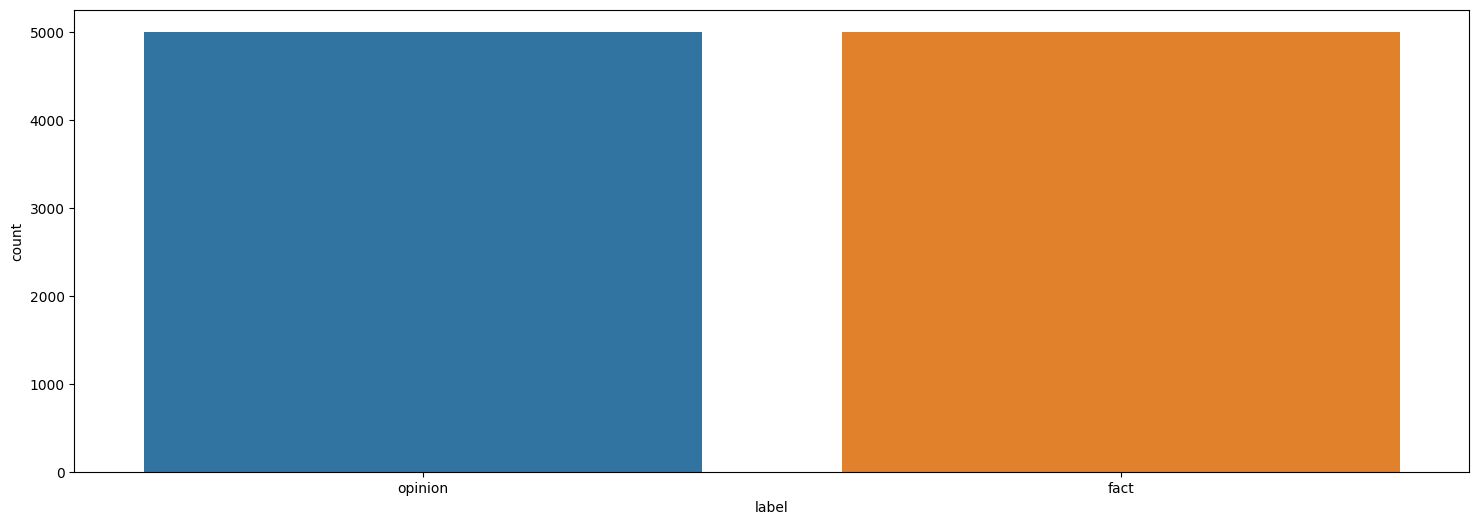

opinion    5000
fact       5000
Name: label, dtype: int64


In [ ]:
# Graph Information:
# ------------------
# Type: Countplot
# Title: Distribution of the "label" Column
# X-axis label: Label
# Y-axis label: Count
# Color: Default

# Graph Description:
# ------------------
# This countplot displays the distribution of the "label" column in a dataset. The x-axis represents the unique values of the "label" column, while the y-axis represents the count of each unique value. This graph helps to identify the frequency of each unique value in the "label" column.

# Data Information:
# -----------------
# The dataset used for this graph contains a column named "label".

# Note:
# -----
# The countplot assumes that the "label" column contains categorical data.

# Code Output:
# ------------
# The output of this code is a countplot that displays the distribution of the "label" column. Additionally, the value counts of the "label" column are printed to the console.

# What is the distribution of the opinions and facts in the dataset?
# --------------------------------
# graph shows 50 - 50 distribution of opinions and facts in the dataset.

# Plot the distribution of the "label" column
sns.countplot(x='label', data=data_tfidf)
plt.show()

# Print the value counts of the "label" column
print(data_tfidf['label'].value_counts())

## **Word Count - Statistics**

In [ ]:
# Split Article Text Into Words

data_tfidf['full_text_words'] = data_tfidf['full_text_cleaned'].apply(lambda x: nltk.word_tokenize(x.lower()))

In [ ]:
data_tfidf.head()

label                                          full_text  \
0  opinion  Is Bernie Sanders really happening?. Watching ...   
1  opinion  The London terror attack would’ve been much wo...   
2  opinion  The Super Bowl poses the question: What’s more...   
3  opinion  On health care, is Trump malicious or just inc...   
4  opinion  What ever happened to that ‘head on a pike’ st...   

                                   full_text_cleaned  \
0  biter purse tammy abnormal water doubly throat...   
1  count lethal suicide kill include change vest ...   
2  huge career play count screen beauty malfuncti...   
3  falsely service ignorance policy meeting profe...   
4  atmosphere white believe schiff house directly...   

                                     full_text_words  
0  [biter, purse, tammy, abnormal, water, doubly,...  
1  [count, lethal, suicide, kill, include, change...  
2  [huge, career, play, count, screen, beauty, ma...  
3  [falsely, service, ignorance, policy, meeting,...  
4  [atmosphere, white, believe, schiff, house, di...

In [ ]:
data_tfidf['word_count'] = data_tfidf['full_text_words'].apply(lambda x: len(x))

In [ ]:
data_tfidf.head()

label                                          full_text  \
0  opinion  Is Bernie Sanders really happening?. Watching ...   
1  opinion  The London terror attack would’ve been much wo...   
2  opinion  The Super Bowl poses the question: What’s more...   
3  opinion  On health care, is Trump malicious or just inc...   
4  opinion  What ever happened to that ‘head on a pike’ st...   

                                   full_text_cleaned  \
0  biter purse tammy abnormal water doubly throat...   
1  count lethal suicide kill include change vest ...   
2  huge career play count screen beauty malfuncti...   
3  falsely service ignorance policy meeting profe...   
4  atmosphere white believe schiff house directly...   

                                     full_text_words  word_count  
0  [biter, purse, tammy, abnormal, water, doubly,...         269  
1  [count, lethal, suicide, kill, include, change...         152  
2  [huge, career, play, count, screen, beauty, ma...         255  
3  [falsely, service, ignorance, policy, meeting,...         283  
4  [atmosphere, white, believe, schiff, house, di...          52

In [ ]:
# Min Word Count

print('Min Word Count In All Articles: ',data_tfidf['word_count'].min())
print('Min Word Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['word_count'].min())
print('Min Word Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['word_count'].min())

Min Word Count In All Articles:  6
Min Word Count In Fact Articles:  11
Min Word Count In Opinion Articles:  6


In [ ]:
# Max Word Count

print('Max Word Count In All Articles: ',data_tfidf['word_count'].max())
print('Max Word Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['word_count'].max())
print('Max Word Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['word_count'].max())

Max Word Count In All Articles:  1374
Max Word Count In Fact Articles:  887
Max Word Count In Opinion Articles:  1374


In [ ]:
# Mean Word Count

print('Mean Word Count In All Articles: ',data_tfidf['word_count'].mean())
print('Mean Word Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['word_count'].mean())
print('Mean Word Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['word_count'].mean())

Mean Word Count In All Articles:  164.8499
Mean Word Count In Fact Articles:  123.6782
Mean Word Count In Opinion Articles:  206.0216


In [ ]:
# Median Word Count

print('Median Word Count In All Articles: ',data_tfidf['word_count'].median())
print('Median Word Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['word_count'].median())
print('Median Word Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['word_count'].median())

Median Word Count In All Articles:  162.0
Median Word Count In Fact Articles:  114.0
Median Word Count In Opinion Articles:  226.0


In [ ]:
# Standard Deviation Word Count

print('Std. Deviation Of Word Count In All Articles: ',data_tfidf['word_count'].std())
print('Std. Deviation Of Word Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['word_count'].std())
print('Std. Deviation Of Word Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['word_count'].std())

Std. Deviation Of Word Count In All Articles:  99.88317693632642
Std. Deviation Of Word Count In Fact Articles:  78.52568434200542
Std. Deviation Of Word Count In Opinion Articles:  101.97114668567417


## **Sentence Count - Statistics**

In [ ]:
# Tokenize Articles Into Sentences
data_tfidf['full_text_sents'] = data_tfidf['full_text'].apply(lambda x: nltk.sent_tokenize(x.lower()))

# Add Column For Sentence Count Value
data_tfidf['sent_count'] = data_tfidf['full_text_sents'].apply(lambda x: len(x))

In [ ]:
# Min Sentence Count

print('Min Sentence Count In All Articles: ',data_tfidf['sent_count'].min())
print('Min Sentence Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['sent_count'].min())
print('Min Sentence Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['sent_count'].min())

Min Sentence Count In All Articles:  1
Min Sentence Count In Fact Articles:  1
Min Sentence Count In Opinion Articles:  2


In [ ]:
# Max Sentence Count

print('Max Sentence Count In All Articles: ',data_tfidf['sent_count'].max())
print('Max Sentence Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['sent_count'].max())
print('Max Sentence Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['sent_count'].max())

Max Sentence Count In All Articles:  521
Max Sentence Count In Fact Articles:  183
Max Sentence Count In Opinion Articles:  521


In [ ]:
# Mean Sentence Count

print('Mean Sentence Count In All Articles: ',data_tfidf['sent_count'].mean())
print('Mean Sentence Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['sent_count'].mean())
print('Mean Sentence Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['sent_count'].mean())

Mean Sentence Count In All Articles:  20.2641
Mean Sentence Count In Fact Articles:  12.8338
Mean Sentence Count In Opinion Articles:  27.6944


In [ ]:
# Median Sentence Count

print('Median Sentence Count In All Articles: ',data_tfidf['sent_count'].median())
print('Median Sentence Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['sent_count'].median())
print('Median Sentence Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['sent_count'].median())

Median Sentence Count In All Articles:  17.0
Median Sentence Count In Fact Articles:  11.0
Median Sentence Count In Opinion Articles:  29.0


In [ ]:
# Std. Deviation Sentence Count

print('Std. Deviation Of Sentence Count In All Articles: ',data_tfidf['sent_count'].std())
print('Std. Deviation Of Sentence Count In Fact Articles: ',data_tfidf[data_tfidf['label']=='fact']['sent_count'].std())
print('Std. Deviation Of Sentence Count In Opinion Articles: ',data_tfidf[data_tfidf['label']=='opinion']['sent_count'].std())

Std. Deviation Of Sentence Count In Fact Articles:  10.004108855805185
Std. Deviation Of Sentence Count In Opinion Articles:  20.202421543152727


## **Unique Words Count Comparison**

In [ ]:
# Extract All Words From Fact Articles
fact_text_words = data_tfidf[data_tfidf['label']=='fact']['full_text_words']

# Initialize An Empty List
fact_words = []

# Combine Word Lists Of All Fact Articles Into A Single List
for article_word_list in fact_text_words:
    fact_words = fact_words + article_word_list

# Output Check
print(type(fact_words))
print(len(fact_words))

<class 'list'>
618391


In [ ]:
# Extract All Words From Fact Articles

opinion_text_words = data_tfidf[data_tfidf['label']=='opinion']['full_text_words']

# Initialize An Empty List
opinion_words = []

# Combine Word Lists Of All Fact Articles Into A Single List
for article_word_list in opinion_text_words:
    opinion_words = opinion_words + article_word_list

# Output Check
print(type(opinion_words))
print(len(opinion_words))

<class 'list'>
1030108


In [ ]:
fact_words_unique = set(fact_words)
opinion_words_unique = set(opinion_words)

print('Fact Text Word Count After Cleaning: ',len(fact_words_unique))
print('Opinion Text Word Count After Cleaning: ',len(opinion_words_unique))

Fact Text Word Count After Cleaning:  24442
Opinion Text Word Count After Cleaning:  33147


## **Scatterplot - Word Count Vs Sent Count**

In [ ]:
import plotly.express as px

fig = px.scatter(data_tfidf,x='word_count',y='sent_count',color='label')
fig.update_xaxes(range=[0,1500],dtick=500)
fig.show()

## **Most Frequent Words**

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Tokenize the "full_text" column
tokens = [word.lower() for text in data_tfidf['full_text_cleaned'] for word in word_tokenize(text)]

# Calculate the frequency distribution of each word
freq_dist = FreqDist(tokens)

# Print the 10 most common words
print(freq_dist.most_common(10))

[('would', 5417), ('year', 5246), ('reuters', 4869), ('make', 4649), ('also', 4473), ('state', 4421), ('president', 4166), ('take', 4158), ('time', 3907), ('people', 3888)]


## **Evaluate Sentiment Score**

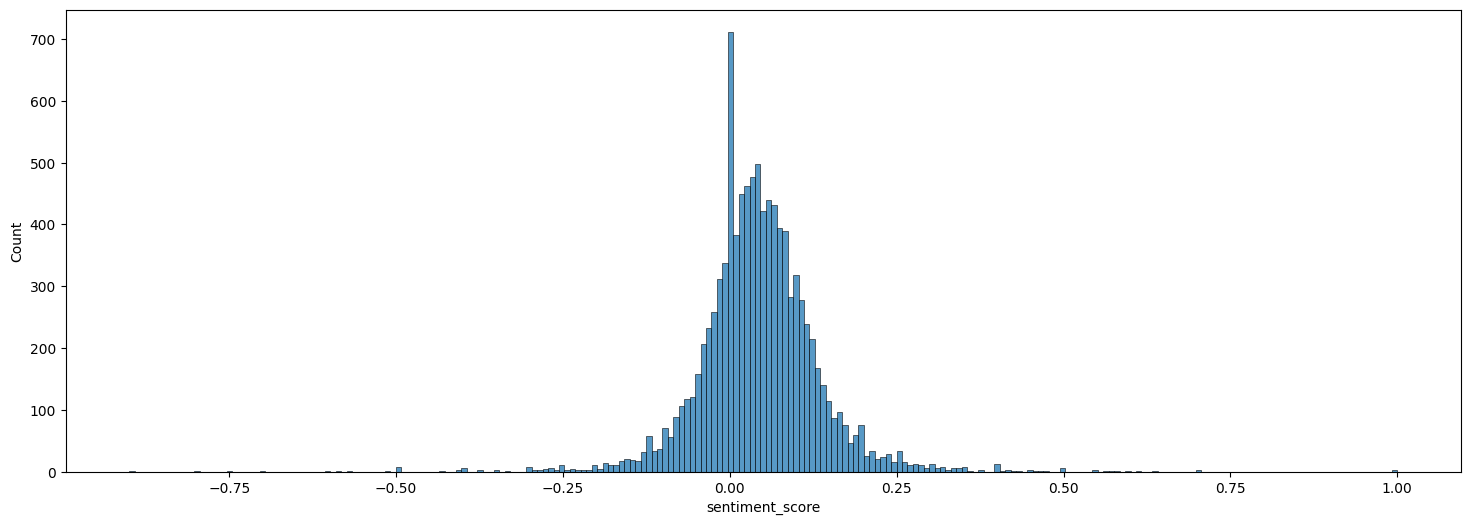

In [ ]:
# Graph Information:
# ------------------
# Type: Histogram
# Title: Distribution of Sentiment Scores in Text Data
# X-axis label: Sentiment Score
# Y-axis label: Frequency
# Color: Default

# Graph Description:
# ------------------
# This histogram displays the distribution of sentiment scores for text data. The x-axis represents the sentiment score ranging from -1 (negative sentiment) to 1 (positive sentiment), while the y-axis represents the frequency of sentiment scores. This graph helps to identify the distribution of sentiment scores and whether the text data is mostly positive, negative, or neutral.

# Data Information:
# -----------------
# The dataset used for this graph contains a column named "body" that contains text data.

# Note:
# -----
# The sentiment scores are calculated using the TextBlob library, which assigns a polarity score ranging from -1 to 1 based on the sentiment of the text. The histogram assumes that sentiment scores range from -1 to 1.

# Code Output:
# ------------
# The output of this code is a histogram that displays the distribution of sentiment scores for the text data in the "body" column of the dataset.

# How is the distribution of the sentiment value for the text data in data set?
#-----------------------------------------------------------------------------
#The graph shows that the text is slightly on the positive sentiment.

from textblob import TextBlob

# Define a function to calculate the sentiment score of a text
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Calculate the sentiment score of the "body" column
data_tfidf['sentiment_score'] = data_tfidf['full_text_cleaned'].apply(calculate_sentiment)

# Plot the distribution of the sentiment scores
sns.histplot(data_tfidf['sentiment_score'])
plt.show()

## **Word Cloud - Full Text**

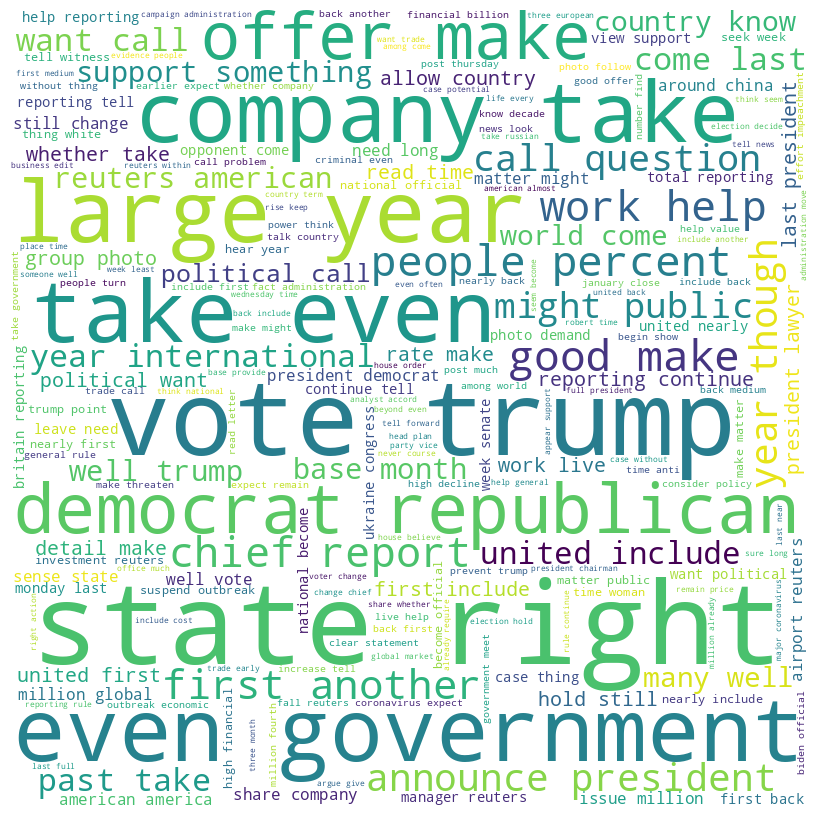

In [ ]:


# Graph Information:
# ------------------
# Type: Word Cloud
# Title: Word Cloud of Full Text Data
# Color: Default

# Graph Description:
# ------------------
# This word cloud displays the most common words in the "full_text" column of the data. The size of each word corresponds to its frequency in the text data.

# Data Information:
# -----------------
# The dataset used for this graph contains a column named "full_text" that contains text data.

# Note:
# -----
# The word cloud assumes that words are separated by spaces.

# Code Output:
# ------------
# The output of this code is a word cloud that displays the most common words in the "full_text" column of the dataset.



from wordcloud import WordCloud

# Generate a word cloud for the "full_text" column
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(' '.join(data_tfidf['full_text_cleaned']))

# Plot the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## **Pie Chart - 10 Most Frequent Words**

In [ ]:
from collections import Counter

# Get the list of all words in the "full_text" column
all_words = [word.lower() for text in data_tfidf['full_text_cleaned'] for word in word_tokenize(text)]

# Count the frequency of each word
word_freq = Counter(all_words)

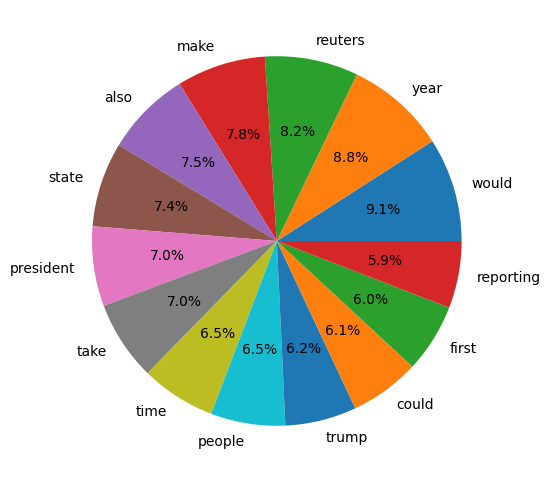

In [ ]:
# Graph Information:
# ------------------
# Type: Pie Chart
# Title: Top 10 Most Common Words in Text Data
# Color: Default

# Graph Description:
# ------------------
# This pie chart displays the distribution of the top 10 most common words in text data. The chart shows the percentage of each word's frequency in the data, allowing for quick identification of the most frequently used words.

# Data Information:
# -----------------
# The dataset used for this graph contains a column named "body" that contains text data.

# Note:
# -----
# The code removes certain characters from the top_words dictionary to make the graph more visually appealing.

# Code Output:
# ------------
# The output of this code is a pie chart that displays the distribution of the top 10 most common words in the text data. 

# What are the percentages of the common words in both opinions and facts?
# ---------------------
# 'The' is most commonly used in opinions and facts, followed by 'to'. this ends with 'for' which is used the least.

# Get the top 10 most common words
top_words = dict(word_freq.most_common(14))

# Plot the count of the top 10 most common words
plt.pie(labels=list(top_words.keys()), x=list(top_words.values()), autopct='%1.1f%%')
plt.show()

## **Identify Countries From Articles**

In [ ]:
# creating a new dataframe
facts = data_tfidf[data_tfidf['label']=="fact"]
opinions = data_tfidf[data_tfidf['label']=="opinion"]

In [ ]:
import re

!pip install pycountry
import pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 86.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681847 sha256=164001ba1deb422c5a07a9f32fb971d3f920704bf4496781a2c5d1b54790fb59
  Stored in directory: /root/.cache/pip/wheels/47/15/92/e6dc85fcb0686c82e1edbcfdf80cfe4808c058813fed0baa8f
Successfully built pycountry


In [ ]:
# Start Timer
import time
start_time = time.time()

#extraction of countries from each clean text

facts = data_tfidf[data_tfidf['label']=="fact"]
opinions = data_tfidf[data_tfidf['label']=="opinion"]

def extract_countries(text):
    """
    Extracts countries from the given text using pycountry.
    """
    countries = set()
    for country in pycountry.countries:
        name_regex = r'\b{}\b'.format(country.name)
        alpha_2_regex = r'\b{}\b'.format(country.alpha_2)
        alpha_3_regex = r'\b{}\b'.format(country.alpha_3)
        if re.search(name_regex, text, re.IGNORECASE) or \
           re.search(alpha_2_regex, text, re.IGNORECASE) or \
           re.search(alpha_3_regex, text, re.IGNORECASE):
            countries.add(country.name)
    return ', '.join(sorted(countries))

opinions['Countries'] = opinions['full_text_cleaned'].apply(extract_countries)
facts['Countries'] = facts['full_text_cleaned'].apply(extract_countries)

# Count Time Timer
print('\n','Processing Time: ', (time.time()-start_time))
del start_time

<ipython-input-75-8b1ba88ac2d3>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 Processing Time:  453.0833480358124


<ipython-input-75-8b1ba88ac2d3>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
trailfacts = facts
trailopinions = opinions

## **Article Count Per Country**

In [ ]:
#FACTS count for each country

import pandas as pd
import pycountry

# create a list of country names
countries = [country.name for country in pycountry.countries]

# create a DataFrame with one column of country names
df1 = pd.DataFrame(countries, columns=['country'])

# set the count to 0 for all countries
df1['count'] = 0

# loop through each row in the sample DataFrame
for index, row in trailfacts.iterrows():
    # split the countries column by commas
    country_list = row['Countries'].split(',')
    # strip any whitespace from the country names
    country_list = [country.strip() for country in country_list]
    # loop through each country in the list and update the count in the main DataFrame
    for country in country_list:
        if country in df1['country'].values:
            df1.loc[df1['country'] == country, 'count'] += 1
    df1 = df1.sort_values(by='count',ascending=False)

# print the final DataFrame
df1

country  count
43                              China   1869
75                             France    509
115                             Japan    457
59                            Germany    407
14                          Australia    361
..                                ...    ...
228         Taiwan, Province of China      0
76                      Faroe Islands      0
35                             Bhutan      0
169                             Nauru      0
237  Saint Vincent and the Grenadines      0

[249 rows x 2 columns]

In [ ]:
# OPINIONS count for each country

import pandas as pd
import pycountry

# create a list of country names
countries = [country.name for country in pycountry.countries]

# create a DataFrame with one column of country names
df2 = pd.DataFrame(countries, columns=['country'])

# set the count to 0 for all countries
df2['count'] = 0

# loop through each row in the sample DataFrame
for index, row in trailopinions.iterrows():
    # split the countries column by commas
    country_list = row['Countries'].split(',')
    # strip any whitespace from the country names
    country_list = [country.strip() for country in country_list]
    # loop through each country in the list and update the count in the main DataFrame
    for country in country_list:
        if country in df2['country'].values:
            df2.loc[df2['country'] == country, 'count'] += 1
    df2 = df2.sort_values(by='count',ascending=False)

# print the final DataFrame
df2

country  count
231                   Ukraine   1042
43                      China    510
108                      Iraq    215
226                    Turkey    165
142                    Mexico    153
..                        ...    ...
83                  Gibraltar      0
174                  Pitcairn      0
240      Virgin Islands, U.S.      0
38   Central African Republic      0
50                    Comoros      0

[249 rows x 2 columns]

## **Geographic Heatmap Comparison**

In [ ]:
# Graph Information:
# ------------------
# Type: Map
# Title: Number of opinions per Country
# Color: Yellow to red color scheme

# Graph Description:
# ------------------
# This map displays the number of opinions per country using the Yellow to red color scheme. Each country is colored based on the number of opinions present in the dataset. The darker the color, the higher the number of opinions for that country. The map helps to identify the countries with the highest and lowest number of opinions.

# Data Information:
# -----------------
# The dataset used for this map contains two columns: "country" and "count". The "country" column contains the name of the country, and the "count" column contains the number of opinions for each country.

# Note:
# -----
# The map is non-interactable and is generated using the geopandas library.yellow representing the lowest values and red representing the highest.

# Code Output:
# ------------
# The output of this code is a map that displays the number of opinions per country. The size and color of each country on the map represent the number of opinions present in the dataset. 

# Which countries have the most number of opinions and least number of opinions?
# ---------------------------------
# Ukrain is at number 1 and followed by china and the least is Antartica.


# map depicting the count of opinions per country

import plotly.express as px
import pandas as pd

!pip install geopandas
import geopandas as gpd

# Load the shapefile for world countries
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json')


# Merge the world shapefile with the count data
merged = world.merge(df2, left_on='name', right_on='country')
merged
# Create a Plotly choropleth map
fig = px.choropleth(merged,
                    locations=merged.index,
                    geojson=merged.geometry,
                    color='count',
                    projection='natural earth',
                    color_continuous_scale='YlOrRd',
                    hover_data={'Name of Country':merged['country'], 'count': ':,'},
                    labels={'count': 'Number of opinions'}
                   )

# Add annotations to the map
annotations = [dict(x=row['geometry'].centroid.coords[0][0],
                     y=row['geometry'].centroid.coords[0][1],
                     text=row['name'],
                     showarrow=False,
                     font=dict(size=8),
                     xanchor='center',
                     yanchor='middle'
                    ) for _, row in merged.iterrows()]

fig.update_layout(annotations=annotations,
                  hoverlabel=dict(bgcolor='black', font_size=12, font_family="Arial"),
                  title=dict(text='Number of opinions per Country', font=dict(size=25))
                 )

# Create a trace for country names
name_trace = go.Scattergeo(
    locationmode='ISO-3',
    lon=merged.geometry.centroid.x,
    lat=merged.geometry.centroid.y,
    text=merged['name'],
    mode='text',
    showlegend=False,
    textfont=dict(size=8, color='black')
)

# Add the trace to the map
fig.add_trace(name_trace)
# Show the map
fig.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 69.6 MB/s eta 0:00:00


<ipython-input-79-831d5a7d240e>:74: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


<ipython-input-79-831d5a7d240e>:75: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [ ]:
# Graph Information:
# ------------------
# Type: Map
# Title: Number of Facts per Country
# Color: Yellow to red color scheme

# Graph Description:
# ------------------
# This map displays the number of facts per country using the Yellow to red color scheme. Each country is colored based on the number of facts present in the dataset. The darker the color, the higher the number of facts for that country. The map helps to identify the countries with the highest and lowest number of facts.

# Data Information:
# -----------------
# The dataset used for this map contains two columns: "country" and "count". The "country" column contains the name of the country, and the "count" column contains the number of facts for each country.

# Note:
# -----
# The map is non-interactable and is generated using the geopandas library.yellow representing the lowest values and red representing the highest.

# Code Output:
# ------------
# The output of this code is a map that displays the number of facts per country. The size and color of each country on the map represent the number of facts present in the dataset. 

# Which countries have the most number of facts and least number of facts?
# ---------------------------------
# China is at number 1 and followed by France and the least is Antartica.

# map depicting the count of facts per country

import plotly.express as px
import pandas as pd
import geopandas as gpd

# Load the shapefile for world countries
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json')

# Merge the world shapefile with the count data
merged = world.merge(df1, left_on='name', right_on='country')
merged
# Create a Plotly choropleth map
fig = px.choropleth(merged,
                    locations=merged.index,
                    geojson=merged.geometry,
                    color='count',
                    projection='natural earth',
                    color_continuous_scale='YlOrRd',
                    hover_data={'Name of Country':merged['country'], 'count': ':,'},
                    labels={'count': 'Number of facts'}
                   )

# Add annotations to the map
annotations = [dict(x=row['geometry'].centroid.coords[0][0],
                     y=row['geometry'].centroid.coords[0][1],
                     text=row['name'],
                     showarrow=False,
                     font=dict(size=8),
                     xanchor='center',
                     yanchor='middle'
                    ) for _, row in merged.iterrows()]

fig.update_layout(annotations=annotations,
                  hoverlabel=dict(bgcolor='black', font_size=12, font_family="Arial"),
                  title=dict(text='Number of facts per Country', font=dict(size=25))
                 )

# Create a trace for country names
name_trace = go.Scattergeo(
    locationmode='ISO-3',
    lon=merged.geometry.centroid.x,
    lat=merged.geometry.centroid.y,
    text=merged['name'],
    mode='text',
    showlegend=False,
    textfont=dict(size=8, color='black')
)

# Add the trace to the map
fig.add_trace(name_trace)
# Show the map
fig.show()

<ipython-input-80-2faac6e48125>:70: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


<ipython-input-80-2faac6e48125>:71: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




## **Pie Chart - Intersection Vs Difference Word Set**

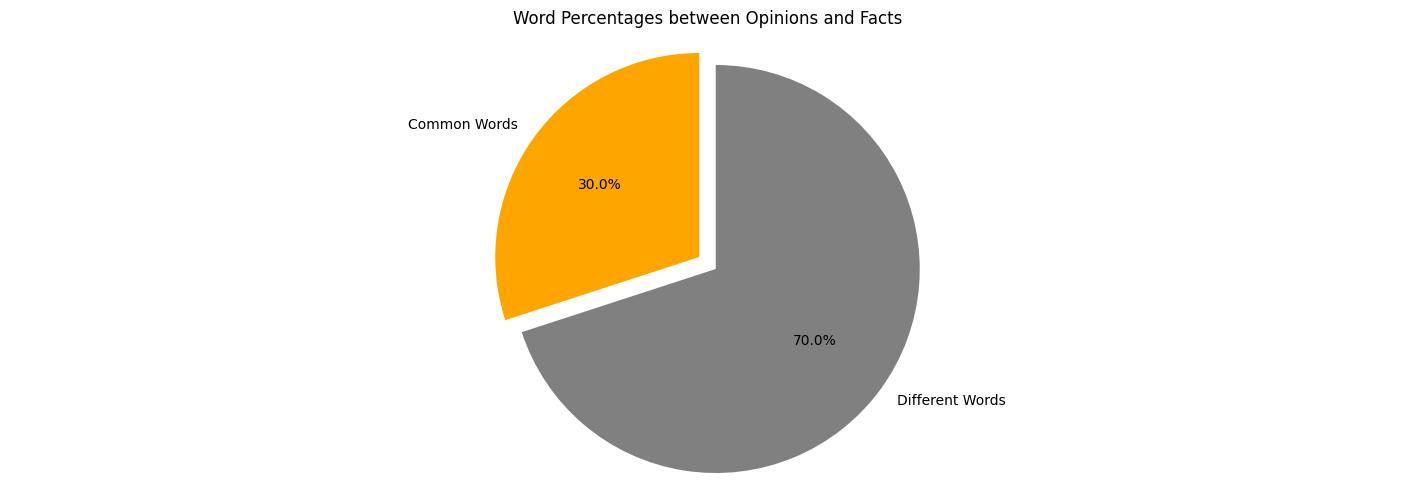

Percentage of common words: 30.01%
Percentage of different words: 69.99%


In [ ]:
# Graph Information:
# ------------------
# Type: Pie Chart
# Title: Word Percentages between Opinions and Facts
# Color: Orange and Grey

# Graph Description:
# ------------------
# A pie chart representing the percentage of common and different words between two sets of texts: opinions and facts.

# Data Information:
# -----------------
# Two sets of texts: opinions and facts. The comma-separated strings in each column are converted to sets of words.
# The intersection and difference between the two sets are calculated.
# The percentage of common and different words is calculated using the length of intersection, difference, opinions_set and facts_set.

# Note:
# -----
# The 1st slice is exploded to highlight the common words.

# Code Output:
# ------------
# The percentage of common and different words between the two sets of texts.

# What is the Percentage of common words in Opinions and Facts?
#------------------------------
# 15.6% of common words in opinions and facts

#pie chart for common and different words


# Convert the comma-separated strings in each column to sets of words
opinions_set = set(opinions['full_text_cleaned'].str.replace(',', '').str.lower().str.split(' ').sum())
facts_set = set(facts['full_text_cleaned'].str.replace(',', '').str.lower().str.split(' ').sum())

# Calculate the intersection and difference between the two sets
intersection = opinions_set.intersection(facts_set)
difference = opinions_set.symmetric_difference(facts_set)

# Calculate the percentage of common and different words
# common_percentage = len(intersection) / len(opinions_set) * 100
# different_percentage = len(difference) / len(opinions_set) * 100
common_percentage = len(intersection) / len(opinions_set.union(facts_set)) * 100
different_percentage = len(difference) / len(opinions_set.union(facts_set)) * 100

# Create a pie chart
labels = ['Common Words', 'Different Words']
sizes = [common_percentage, different_percentage]
colors = ['orange', 'grey']
explode = (0.1, 0)  # explode the 1st slice

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Word Percentages between Opinions and Facts')
plt.show()

# Print the results
print('Percentage of common words: {:.2f}%'.format(common_percentage))
print('Percentage of different words: {:.2f}%'.format(different_percentage))

## **Wordcloud - Fact Articles**

In [ ]:
# Create Combine All Words From Fact Article Into A Single Text String
fact_text = ' '.join(fact_words)

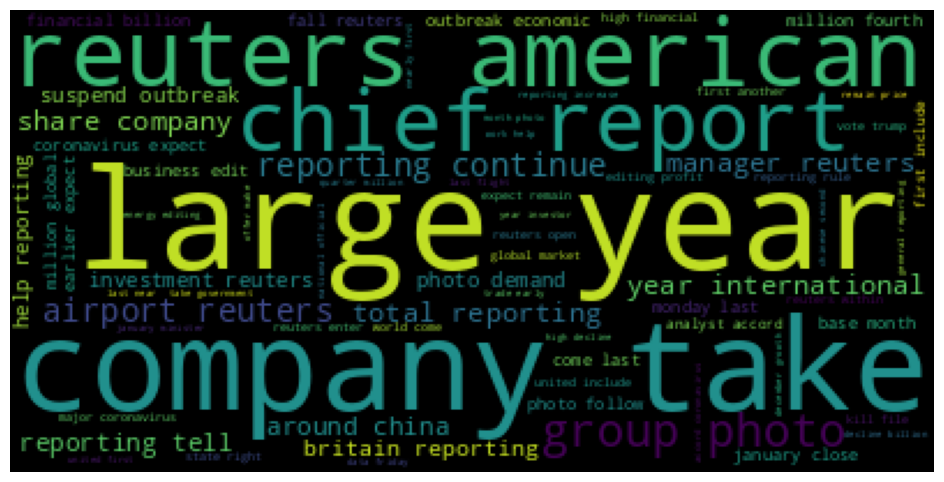

In [ ]:
# Wordcloud For Fact Articles
wordcloud_fact = WordCloud().generate(fact_text)

plt.imshow(wordcloud_fact)
#plt.figure(figsize=(800,1600),dpi=50)
#plt.figure().set_figheight(100)
#plt.figure().set_figwidth(200)
plt.axis("off")
plt.show()

## **Wordcloud - Opinion Articles**

In [ ]:
# Create Combine All Words From Opinion Article Into A Single Text String
opinion_text = ' '.join(opinion_words)

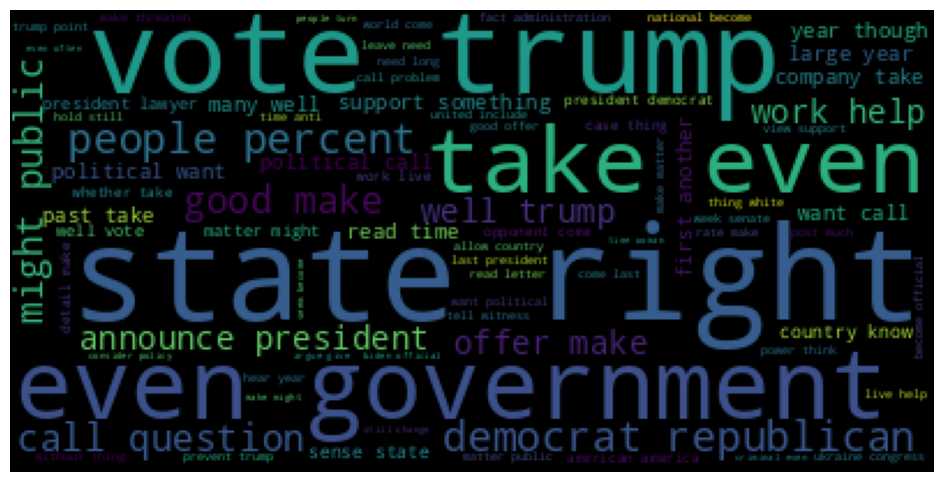

In [ ]:
# Wordcloud For Opinion Articles

wordcloud_opinion = WordCloud().generate(opinion_text)
plt.imshow(wordcloud_opinion)
plt.axis("off")
plt.show()

## **Wordcloud - Intersection Words**

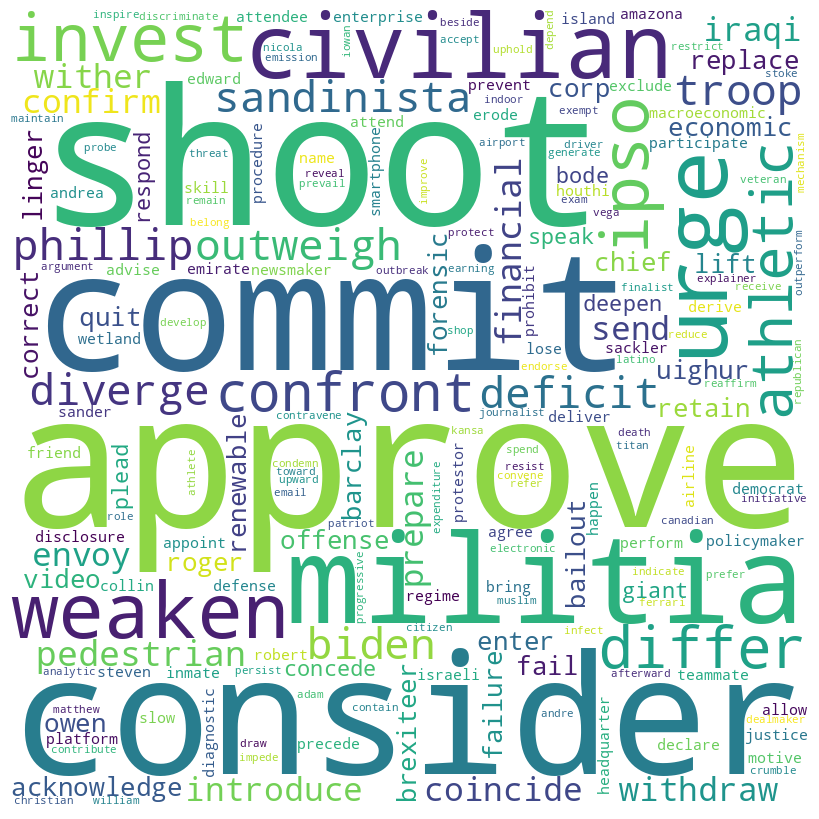

In [ ]:
#word cloud for common words

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join the words in the intersection list
text = ' '.join(intersection)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

# Plot the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Show the plot
plt.show()

# **Data Processing**

## **Train Test Split** 

In [ ]:
data_tfidf.head()

label                                          full_text  \
0  opinion  Is Bernie Sanders really happening?. Watching ...   
1  opinion  The London terror attack would’ve been much wo...   
2  opinion  The Super Bowl poses the question: What’s more...   
3  opinion  On health care, is Trump malicious or just inc...   
4  opinion  What ever happened to that ‘head on a pike’ st...   

                                   full_text_cleaned  \
0  nose hillary respiratory attack counsel leahy ...   
1  also attack access assault occur accord harm c...   
2  today astonishingly actually duet slacker crot...   
3  davos second also qualify enrollment politely ...   
4  high reference story report house confidant be...   

                                     full_text_words  word_count  \
0  [nose, hillary, respiratory, attack, counsel, ...         269   
1  [also, attack, access, assault, occur, accord,...         152   
2  [today, astonishingly, actually, duet, slacker...         255   
3  [davos, second, also, qualify, enrollment, pol...         283   
4  [high, reference, story, report, house, confid...          52   

                                     full_text_sents  sent_count  \
0  [is bernie sanders really happening?., watchin...          42   
1  [the london terror attack would’ve been much w...          19   
2  [the super bowl poses the question: what’s mor...          29   
3  [on health care, is trump malicious or just in...          40   
4  [what ever happened to that ‘head on a pike’ s...           8   

   sentiment_score  
0         0.053208  
1        -0.041026  
2         0.132670  
3         0.034960  
4        -0.041481

In [ ]:
X = data_tfidf.drop(['label','full_text','sentiment_score','full_text_words','word_count','full_text_sents','sent_count'],1)
y = data_tfidf['label']

<ipython-input-89-716c08e087d8>:1: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



In [ ]:
X.head()

full_text_cleaned
0  nose hillary respiratory attack counsel leahy ...
1  also attack access assault occur accord harm c...
2  today astonishingly actually duet slacker crot...
3  davos second also qualify enrollment politely ...
4  high reference story report house confidant be...

In [ ]:
y.head()

0    opinion
1    opinion
2    opinion
3    opinion
4    opinion
Name: label, dtype: object

In [ ]:
# Split Data 

X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=42)

## **Label Encoder**

In [ ]:
le = LabelEncoder()
le.fit_transform(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

## **Model Setup**

In [ ]:
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Bidirectional, Dense, Embedding
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [ ]:
oov_tok = ''
embedding_dim = 100
#padding_type='post'
#trunc_type='post'

## **Extracting Vocabulary**

In [ ]:
total_words = set(X_train[['full_text_cleaned']].stack().str.split("[^\w+]").explode().tolist())

# Specify Vocabulary Size
vocab_size = len(total_words)
print('Vocab Size: ', vocab_size)

## **Fix Embedding Dimension**

In [ ]:
# fixing every word's embedding size to be 50

embd_len = 50
max_length = X_train['full_text_cleaned'].str.split().str.len().max()
print('Max Length: ',max_length)

Vocab Size:  39248
Max Length:  1319


## **Tokenization**

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train['full_text_cleaned'])

## **Padding**

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded = pad_sequences(train_sequences, padding='pre', maxlen=max_length)

In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded = pad_sequences(test_sequences, padding='pre', maxlen=max_length)

## **Tokenizer Word Index**

In [ ]:
word_index = tokenizer.word_index
print(word_index)

{'': 1, 'would': 2, 'year': 3, 'reuters': 4, 'make': 5, 'also': 6, 'state': 7, 'take': 8, 'president': 9, 'time': 10, 'people': 11, 'trump': 12, 'could': 13, 'first': 14, 'reporting': 15, 'report': 16, 'country': 17, 'last': 18, 'even': 19, 'come': 20, 'tell': 21, 'include': 22, 'government': 23, 'call': 24, 'give': 25, 'need': 26, 'like': 27, 'work': 28, 'know': 29, 'many': 30, 'want': 31, 'good': 32, 'show': 33, 'american': 34, 'well': 35, 'back': 36, 'world': 37, 'united': 38, 'help': 39, 'month': 40, 'right': 41, 'week': 42, 'public': 43, 'house': 44, 'national': 45, 'china': 46, 'since': 47, 'political': 48, 'case': 49, 'much': 50, 'support': 51, 'million': 52, 'point': 53, 'still': 54, 'high': 55, 'file': 56, 'company': 57, 'think': 58, 'long': 59, 'policy': 60, 'three': 61, 'official': 62, 'former': 63, 'editing': 64, 'edit': 65, 'plan': 66, 'lead': 67, 'post': 68, 'photo': 69, 'hold': 70, 'leave': 71, 'news': 72, 'part': 73, 'might': 74, 'change': 75, 'republican': 76, 'another

## **TFIDF - Vectorizer**

In [ ]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train["full_text_cleaned"])
vector_train = tfidf.transform(X_train["full_text_cleaned"])
vector_test = tfidf.transform(X_test["full_text_cleaned"])

In [ ]:
vector_train.shape,vector_test.shape

((7000, 39248), (3000, 39248))

# **Model Implementation**

## **Simple RNN Models**

### **Model 01 - Simple RNN 01**

* With Pre Padding

In [ ]:
train_sequences_01 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_01 = pad_sequences(train_sequences_01, padding='pre', maxlen=max_length)

test_sequences_01 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_01 = pad_sequences(test_sequences_01, padding='pre', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_01 = time.time()

# Creating a RNN model
model_01 = Sequential(name="Simple_RNN")
model_01.add(Embedding(vocab_size,embd_len,input_length=max_length))
 
# In case of a stacked(more than one layer of RNN)
# use return_sequences=True
model_01.add(SimpleRNN(128,activation='tanh',return_sequences=False))
model_01.add(Dense(1, activation='sigmoid'))
 
# printing model summary
print(model_01.summary())

# Compiling model
model_01.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])
 
# Training the model
model_01_history = model_01.fit(train_padded_01, y_train,batch_size=64,epochs=5,verbose=1,validation_split=0.25)

# Printing model score on test data
print("Simple_RNN Score---> ", model_01.evaluate(test_padded_01, y_test, verbose=0))

# Stop Timer
stop_time_01 = time.time()
runtime_01 = stop_time_01 - start_time_01
print('\n')
print('Model 01 Procesing Time: ',runtime_01)

Model: "Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1319, 50)          1962400   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               22912     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,985,441
Trainable params: 1,985,441
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
83/83 [==============================] - 113s 1s/step - loss: 0.5828 - accuracy: 0.7057 - val_loss: 0.5993 - val_accuracy: 0.7600
Epoch 2/5
83/83 [==============================] - 106s 1s/step - loss: 0.5355 - accuracy: 0.7832 - val_loss: 0.4434 - val_accuracy: 0.8480
Epoch 3/5
83/83 [========

94/94 [==============================] - 9s 100ms/step
Accuracy of prediction on test set :  0.9833333333333333


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1463
           1       0.98      0.99      0.98      1537

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000

Confusion matrix, without normalization


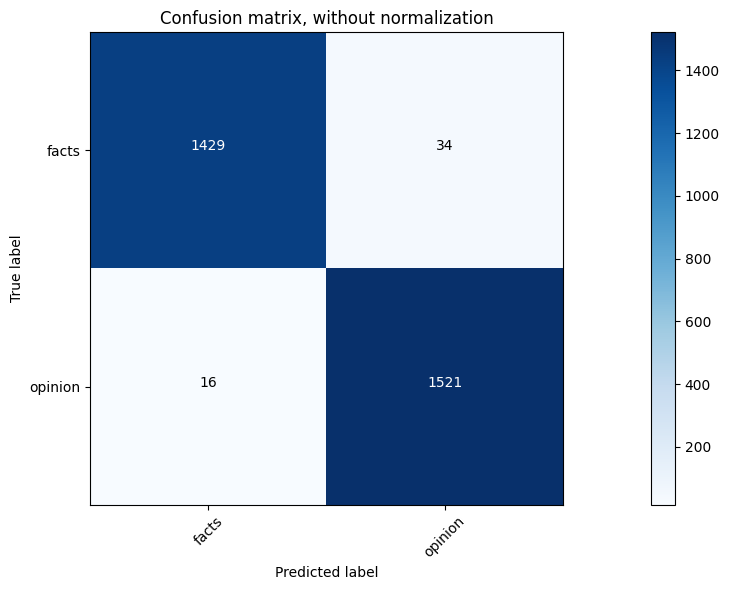

In [ ]:
model_01_pred = model_01.predict(test_padded_01)
y_pred_01 = []

for i in model_01_pred:
    if i >= 0.5:
        y_pred_01.append(1)
    else:
        y_pred_01.append(0)

# Check Model 01 Accuracy & Classification Report

accuracy_01 = accuracy_score(y_test,y_pred_01)
print("Accuracy of prediction on test set : ",accuracy_01)
print('\n')
clf_report_01 = classification_report(y_test,y_pred_01)
print('Classfication Report On Test Set: ','\n',clf_report_01)
f1score_01 = f1_score(y_test,y_pred_01)

# Plot Confusion Matrix
cnf_matrix_01 = confusion_matrix(y_test, y_pred_01)
plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_01, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

### **Model 02 - Simple RNN 02**

* With Post Padding

In [ ]:
train_sequences_02 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_02 = pad_sequences(train_sequences_02, padding='post', maxlen=max_length)

test_sequences_02 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_02 = pad_sequences(test_sequences_02, padding='post', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_02 = time.time()

# Creating a RNN model
model_02 = Sequential(name="Simple_RNN")
model_02.add(Embedding(vocab_size,embd_len,input_length=max_length))
 
# In case of a stacked(more than one layer of RNN)
# Use return_sequences=True
model_02.add(SimpleRNN(128,activation='tanh',return_sequences=False))
model_02.add(Dense(1, activation='sigmoid'))
# Printing model summary
print(model_02.summary())
# Compiling model
model_02.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

# Training the model
model_02_history = model_02.fit(train_padded_02, y_train,batch_size=64,epochs=5,verbose=1,validation_split=0.25)

# Printing model score on test data
print("Simple_RNN Score---> ", model_02.evaluate(test_padded_02, y_test, verbose=0))

# Stop Timer
stop_time_02 = time.time()
runtime_02 = stop_time_02 - start_time_02
print('\n')
print('Model 02 Procesing Time: ',runtime_02)

Model: "Simple_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1319, 50)          1962400   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               22912     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,985,441
Trainable params: 1,985,441
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
83/83 [==============================] - 106s 1s/step - loss: 0.7016 - accuracy: 0.5008 - val_loss: 0.6838 - val_accuracy: 0.5771
Epoch 2/5
83/83 [==============================] - 102s 1s/step - loss: 0.6976 - accuracy: 0.5029 - val_loss: 0.7099 - val_accuracy: 0.4440
Epoch 3/5
83/83 [========

94/94 [==============================] - 10s 110ms/step
Accuracy of prediction on test set :  0.41233333333333333


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.43      0.68      0.53      1463
           1       0.34      0.16      0.22      1537

    accuracy                           0.41      3000
   macro avg       0.39      0.42      0.37      3000
weighted avg       0.39      0.41      0.37      3000

Confusion matrix, without normalization


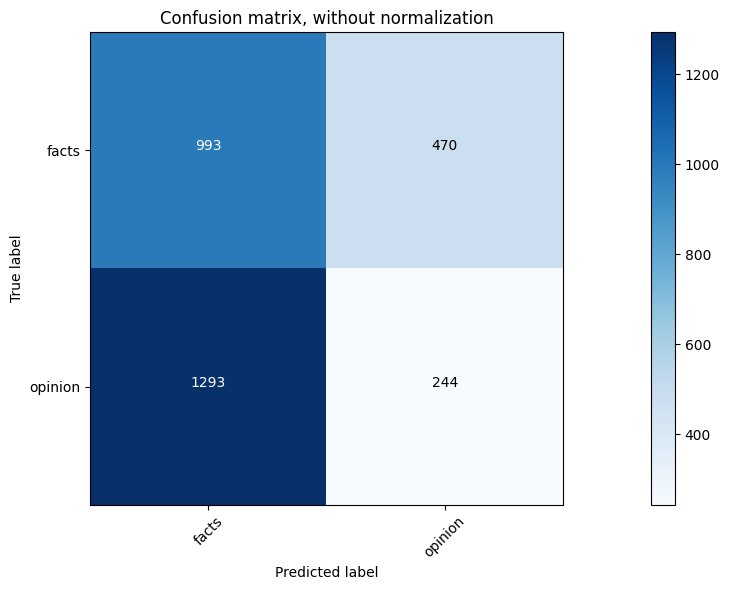

In [ ]:
model_02_pred = model_02.predict(test_padded_02)
y_pred_02 = []

for i in model_02_pred:
    if i >= 0.5:
        y_pred_02.append(1)
    else:
        y_pred_02.append(0)

# Check Model 02 Accuracy & Classification Report

accuracy_02 = accuracy_score(y_test,y_pred_02)
print("Accuracy of prediction on test set : ", accuracy_02)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_02))
f1score_02 = f1_score(y_test,y_pred_02)

# Plot Confusion Matrix
cnf_matrix_02 = confusion_matrix(y_test, y_pred_02)
#np.set_printoptions(precision=2)
plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_02, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

## **GRU Models**

### **Model 03 - GRU 01**

* With Pre Padding

In [ ]:
train_sequences_03 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_03 = pad_sequences(train_sequences_03, padding='pre', maxlen=max_length)

test_sequences_03 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_03 = pad_sequences(test_sequences_03, padding='pre', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_03 = time.time()

# Defining GRU model
model_03 = Sequential(name="GRU_Model")
model_03.add(Embedding(vocab_size,embd_len,input_length=max_length))
model_03.add(GRU(128,activation='tanh',return_sequences=False))
model_03.add(Dense(1, activation='sigmoid'))

# Printing the Summary
print(model_03.summary())

# Compiling the model
model_03.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

# Training the GRU model
model_03_history = model_03.fit(train_padded_03, y_train,batch_size=64,epochs=5,verbose=1,validation_split=0.25)

# Printing model score on test data
print("GRU model Score---> ", model_03.evaluate(test_padded_03, y_test, verbose=0))

# Stop Timer
stop_time_03 = time.time()
runtime_03 = stop_time_03 - start_time_03
print('\n')
print('Model 03 Procesing Time: ',runtime_03)

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1319, 50)          1962400   
                                                                 
 gru (GRU)                   (None, 128)               69120     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,031,649
Trainable params: 2,031,649
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
83/83 [==============================] - 23s 241ms/step - loss: 0.4624 - accuracy: 0.8156 - val_loss: 0.1777 - val_accuracy: 0.9406
Epoch 2/5
83/83 [==============================] - 18s 214ms/step - loss: 0.0591 - accuracy: 0.9827 - val_loss: 0.0338 - val_accuracy: 0.9891
Epoch 3/5
83/83 [=====

In [ ]:
model_03_pred = model_03.predict(test_padded_03)

y_pred_03 = []
for i in model_03_pred:
    if i >= 0.5:
        y_pred_03.append(1)
    else:
        y_pred_03.append(0)

94/94 [==============================] - 2s 14ms/step


Accuracy of prediction on test set :  0.9876666666666667


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1463
           1       0.99      0.99      0.99      1537

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix, without normalization


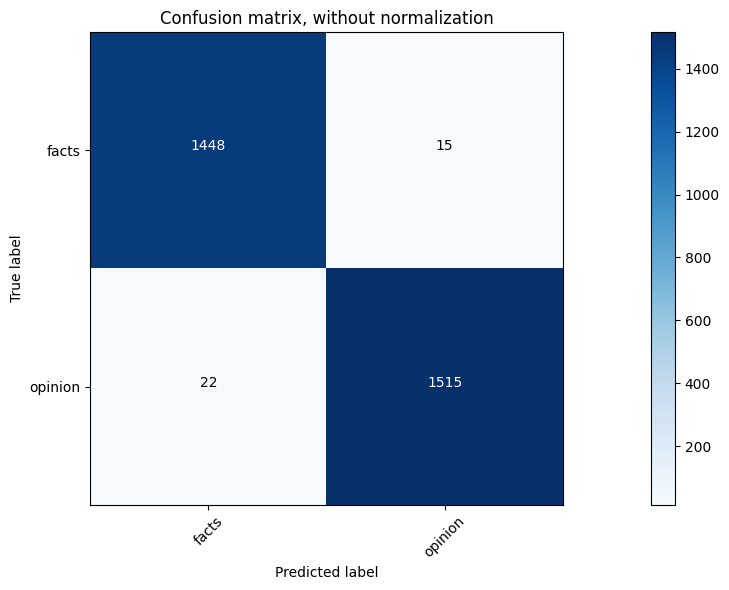

In [ ]:
# Check Model 01 Accuracy & Classification Report

accuracy_03 = accuracy_score(y_test,y_pred_03)
print("Accuracy of prediction on test set : ", accuracy_03)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_03))
f1score_03 = f1_score(y_test,y_pred_03)

# Plot Confusion Matrix
cnf_matrix_03 = confusion_matrix(y_test, y_pred_03)
np.set_printoptions(precision=2)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_03, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

### **Model 04 - GRU 02**

* With Post Padding

In [ ]:
train_sequences_04 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_04 = pad_sequences(train_sequences_04, padding='post', maxlen=max_length)

test_sequences_04 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_04 = pad_sequences(test_sequences_04, padding='post', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_04 = time.time()

# Defining GRU model
model_04 = Sequential(name="GRU_Model")
model_04.add(Embedding(vocab_size,embd_len,input_length=max_length))
model_04.add(GRU(128,activation='tanh',return_sequences=False))
model_04.add(Dense(1, activation='sigmoid'))

# Printing the Summary
print(model_04.summary())

# Compiling the model
model_04.compile(loss="binary_crossentropy",optimizer='adam',metrics=['accuracy'])

# Training the GRU model
model_04_history = model_04.fit(train_padded_04, y_train,batch_size=64,epochs=5,verbose=1,validation_split=0.25)

# Printing model score on test data
print("GRU model Score---> ", model_04.evaluate(test_padded_04, y_test, verbose=0))

# Stop Timer
stop_time_04 = time.time()
runtime_04 = stop_time_04 - start_time_04
print('\n')
print('Model 03 Procesing Time: ',runtime_04)

Model: "GRU_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1319, 50)          1962400   
                                                                 
 gru_1 (GRU)                 (None, 128)               69120     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,031,649
Trainable params: 2,031,649
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
83/83 [==============================] - 21s 225ms/step - loss: 0.6934 - accuracy: 0.5072 - val_loss: 0.6932 - val_accuracy: 0.4971
Epoch 2/5
83/83 [==============================] - 17s 203ms/step - loss: 0.6939 - accuracy: 0.4985 - val_loss: 0.6933 - val_accuracy: 0.4971
Epoch 3/5
83/83 [=====

In [ ]:
model_04_pred = model_04.predict(test_padded_04)

y_pred_04 = []
for i in model_04_pred:
    if i >= 0.5:
        y_pred_04.append(1)
    else:
        y_pred_04.append(0)

94/94 [==============================] - 2s 14ms/step


Accuracy of prediction on test set :  0.4876666666666667


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.49      1.00      0.66      1463
           1       0.00      0.00      0.00      1537

    accuracy                           0.49      3000
   macro avg       0.24      0.50      0.33      3000
weighted avg       0.24      0.49      0.32      3000

Confusion matrix, without normalization


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



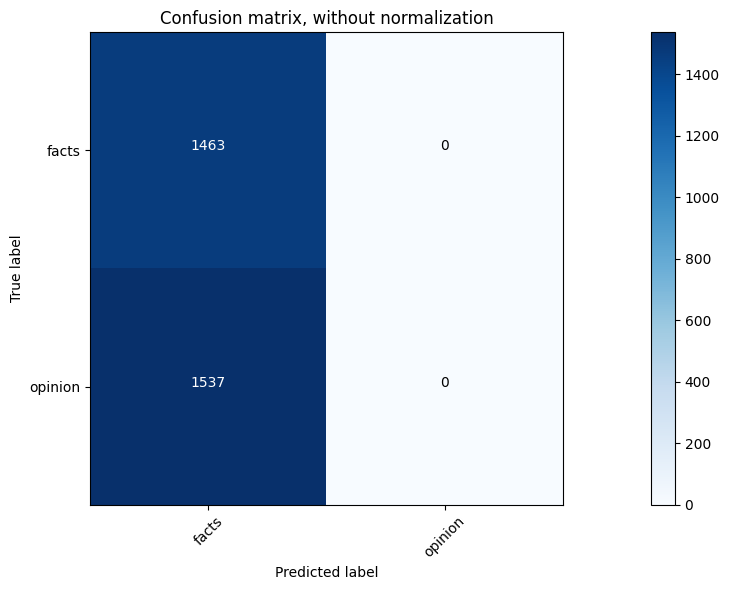

In [ ]:
# Check Model 04 Accuracy & Classification Report

accuracy_04 = accuracy_score(y_test,y_pred_04)
print("Accuracy of prediction on test set : ", accuracy_04)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_04))
f1score_04 = f1_score(y_test,y_pred_04)

# Plot Confusion Matrix
cnf_matrix_04 = confusion_matrix(y_test, y_pred_04)
np.set_printoptions(precision=2)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_04, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

## **LSTM Models**

### **Model 05 - LSTM 03**

* Uni Directional
* Pre Padding

In [ ]:
train_sequences_05 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_05 = pad_sequences(train_sequences_05, padding='pre', maxlen=max_length)

test_sequences_05 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_05 = pad_sequences(test_sequences_05, padding='pre', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_05 = time.time()

import keras
model_05 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(64),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_05.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_05.summary()

model_05_history = model_05.fit(train_padded_05, y_train,epochs=5, verbose=1,validation_split=0.25)

# Stop Timer
stop_time_05 = time.time()
runtime_05 = stop_time_05 - start_time_05
print('\n')
print('Model 05 Procesing Time: ',runtime_05)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1319, 100)         3924800   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,968,625
Trainable params: 3,968,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
165/165 [==============================] - 43s 248ms/step - loss: 0.2125 - accuracy: 0.9295 - val_loss: 0.0475 - val_accuracy: 0.9840
Epoch 2/5
165/165 [===============

94/94 [==============================] - 2s 18ms/step
Accuracy of prediction on test set :  0.9886666666666667


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1463
           1       0.98      0.99      0.99      1537

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix, without normalization


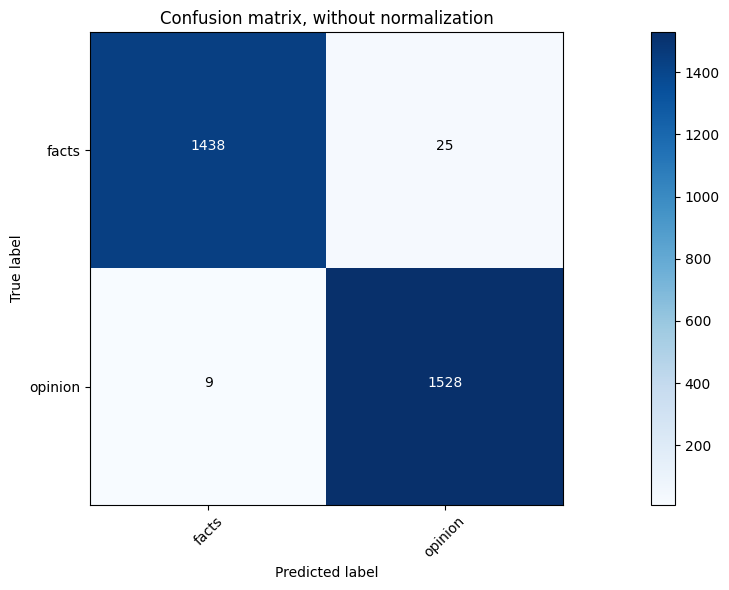

In [ ]:
model_05_pred = model_05.predict(test_padded_05)
y_pred_05 = []

for i in model_05_pred:
    if i >= 0.5:
        y_pred_05.append(1)
    else:
        y_pred_05.append(0)
        
# Check Model 07 Accuracy & Classification Report

accuracy_05 = accuracy_score(y_test,y_pred_05)
print("Accuracy of prediction on test set : ", accuracy_05)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_05))
f1score_05 = f1_score(y_test,y_pred_05)

# Plot Confusion Matrix
cnf_matrix_05 = confusion_matrix(y_test, y_pred_05)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_05, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

### **Model 06 - LSTM 04**

* Uni Directional
* Post Padding

In [ ]:
train_sequences_06 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_06 = pad_sequences(train_sequences_06, padding='post', maxlen=max_length)

test_sequences_06 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_06 = pad_sequences(test_sequences_06, padding='post', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_06 = time.time()

import keras
model_06 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(64),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_06.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_06.summary()

model_06_history = model_06.fit(train_padded_06, y_train,epochs=5, verbose=1,validation_split=0.25)

# Stop Timer
stop_time_06 = time.time()
runtime_06 = stop_time_06 - start_time_06
print('\n')
print('Model 06 Procesing Time: ',runtime_06)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 1319, 100)         3924800   
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 3,968,625
Trainable params: 3,968,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
165/165 [==============================] - 37s 208ms/step - loss: 0.6933 - accuracy: 0.5053 - val_loss: 0.6931 - val_accuracy: 0.5029
Epoch 2/5
165/165 [=============

94/94 [==============================] - 2s 19ms/step
Accuracy of prediction on test set :  0.488


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.49      1.00      0.66      1463
           1       1.00      0.00      0.00      1537

    accuracy                           0.49      3000
   macro avg       0.74      0.50      0.33      3000
weighted avg       0.75      0.49      0.32      3000

Confusion matrix, without normalization


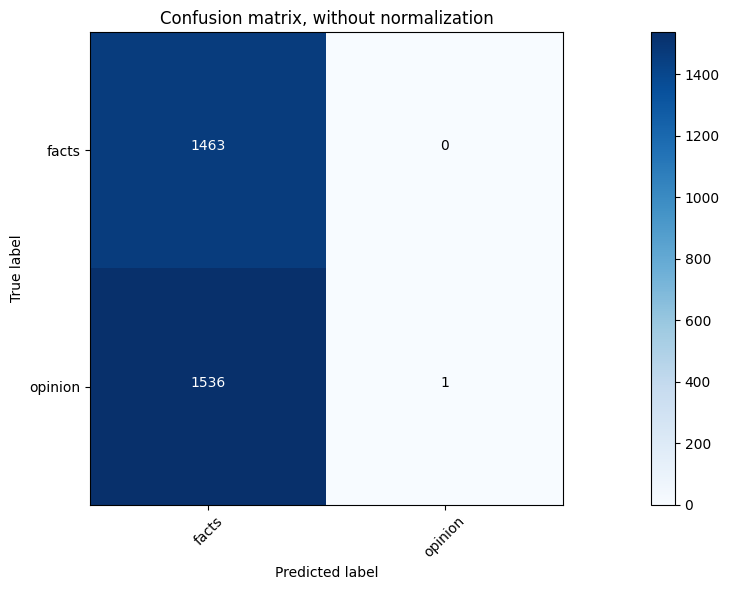

In [ ]:
model_06_pred = model_06.predict(test_padded_06)
y_pred_06 = []

for i in model_06_pred:
    if i >= 0.5:
        y_pred_06.append(1)
    else:
        y_pred_06.append(0)
        
# Check Model 02 Accuracy & Classification Report

accuracy_06 = accuracy_score(y_test,y_pred_06)
print("Accuracy of prediction on test set : ", accuracy_06)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_06))
f1score_06 = f1_score(y_test,y_pred_06)

# Plot Confusion Matrix
cnf_matrix_06 = confusion_matrix(y_test, y_pred_06)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_06, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

## **Bi Directional LSTM Models**

### **Model 07 - Bi Directional LSTM 01**

* Bi Directional Network
* With "Pre" Padding
* Embedding Dimension = 50
* LSTM 01 Layer Cell QTY = 64
* Hidden Layer 01 Cell QTY = 24
* Hidden Layer 02 Cell QTY = 1

In [ ]:
train_sequences_07 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_07 = pad_sequences(train_sequences_07, padding='pre', maxlen=max_length)

test_sequences_07 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_07 = pad_sequences(test_sequences_07, padding='pre', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_07 = time.time()

import keras
model_07 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_07.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_07.summary()

model_07_history = model_07.fit(train_padded_07, y_train,epochs=5, verbose=1,validation_split=0.25)

# Stop Timer
stop_time_07 = time.time()
runtime_07 = stop_time_07 - start_time_07
print('\n')
print('Model 07 Procesing Time: ',runtime_07)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1319, 100)         3924800   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 24)                3096      
                                                                 
 dense_13 (Dense)            (None, 1)                 25        
                                                                 
Total params: 4,012,401
Trainable params: 4,012,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
165/165 [==============================] - 42s 225ms/step - loss: 0.2153 - accuracy: 0.9055 - val_lo

94/94 [==============================] - 3s 30ms/step
Accuracy of prediction on test set :  0.9886666666666667


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1463
           1       0.99      0.99      0.99      1537

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix, without normalization


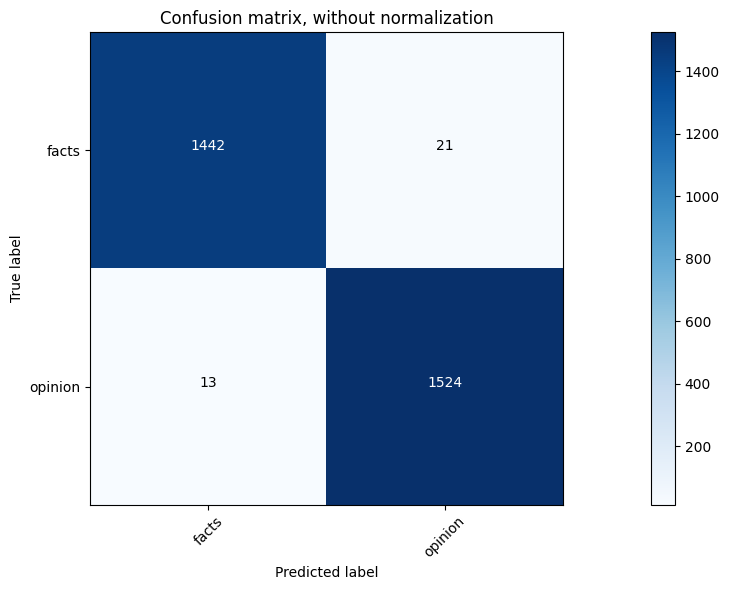

In [ ]:
model_07_pred = model_07.predict(test_padded_07)
y_pred_07 = []

for i in model_07_pred:
    if i >= 0.5:
        y_pred_07.append(1)
    else:
        y_pred_07.append(0)
        
# Check Model 07 Accuracy & Classification Report

accuracy_07 = accuracy_score(y_test,y_pred_07)
print("Accuracy of prediction on test set : ", accuracy_07)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_07))
f1score_07 = f1_score(y_test,y_pred_07)

# Plot Confusion Matrix
cnf_matrix_07 = confusion_matrix(y_test, y_pred_07)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_07, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

### **Model 08 - Bi Directional LSTM 02**

* Bi Directional
* Post Padding
* LSTM 01 Layer Cell QTY = 64
* Hidden Layer 01 Cell QTY = 24
* Hidden Layer 02 Cell QTY = 1

In [ ]:
train_sequences_08 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_08 = pad_sequences(train_sequences_08, padding='post', maxlen=max_length)

test_sequences_08 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_08 = pad_sequences(test_sequences_08, padding='post', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_08 = time.time()

import keras
model_08 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_08.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_08.summary()

model_08_history = model_08.fit(train_padded_08, y_train,epochs=5, verbose=1,validation_split=0.25)

# Stop Timer
stop_time_08 = time.time()
runtime_08 = stop_time_08 - start_time_08
print('\n')
print('Model 08 Procesing Time: ',runtime_08)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1319, 100)         3924800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 24)                3096      
                                                                 
 dense_15 (Dense)            (None, 1)                 25        
                                                                 
Total params: 4,012,401
Trainable params: 4,012,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
165/165 [==============================] - 42s 230ms/step - loss: 0.2135 - accuracy: 0.9143 - val_lo

94/94 [==============================] - 3s 31ms/step
Accuracy of prediction on test set :  0.9746666666666667


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      1463
           1       0.99      0.96      0.97      1537

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.98      0.97      0.97      3000

Confusion matrix, without normalization


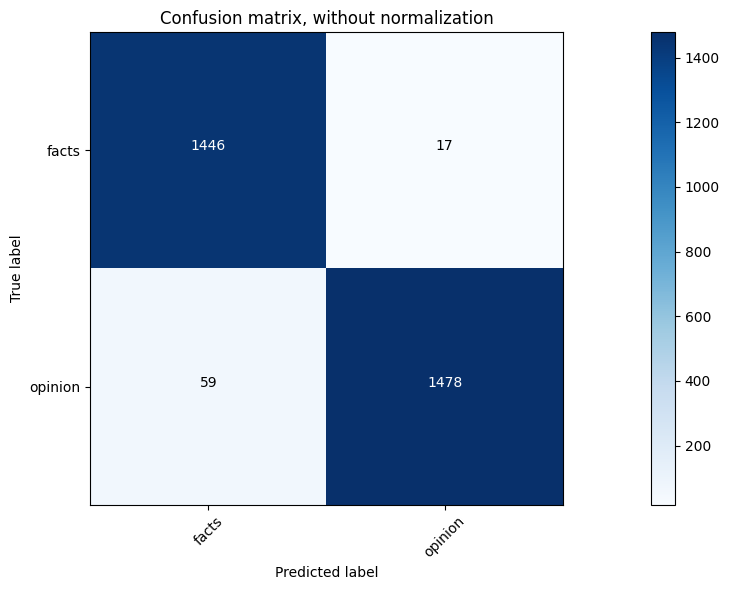

In [ ]:
model_08_pred = model_08.predict(test_padded_08)
y_pred_08 = []

for i in model_08_pred:
    if i >= 0.5:
        y_pred_08.append(1)
    else:
        y_pred_08.append(0)
        
# Check Model 02 Accuracy & Classification Report

accuracy_08 = accuracy_score(y_test,y_pred_08)
print("Accuracy of prediction on test set : ", accuracy_08)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_08))
f1score_08 = f1_score(y_test,y_pred_08)

# Plot Confusion Matrix
cnf_matrix_08 = confusion_matrix(y_test, y_pred_08)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_08, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

## **Exploring Bi Directional LSTM**

Based On The Comparison Of All The Previous Models, we can see that

* Using Post Padding reduces the model performance by a large margin. All the model architectures like RNN, GRU & LSTM show the same behaviour. Hence, we continue to use the default / recommended "Pre Padding""

* One of the interesting things observed is that Bi-Directional LSTM Models are not affected by type of padding. This is a testament to its working technique where the input training data is passed in both forward & backward direction. Hence, we proceed forward with use of Bi Directional LSTM Model.


### **Model 09 - Bi Directional LSTM 03**

Evaluate the model performance when No of Neurons in each layer is halved.

* Bi Directional
* Pre Padding
* LSTM 01 Layer Cell QTY = 32
* Hidden Layer 01 Cell QTY = 12
* Hidden Layer 02 Cell QTY = 1

In [ ]:
train_sequences_09 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_09 = pad_sequences(train_sequences_09, padding='pre', maxlen=max_length)

test_sequences_09 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_09 = pad_sequences(test_sequences_09, padding='pre', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_09 = time.time()

import keras
model_09 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.LSTM(32),
    keras.layers.Dense(12, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_09.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_09.summary()

model_09_history = model_09.fit(train_padded_09, y_train,epochs=5, verbose=1,validation_split=0.25)

# Stop Timer
stop_time_09 = time.time()
runtime_09 = stop_time_09 - start_time_09
print('\n')
print('Model 09 Procesing Time: ',runtime_09)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 1319, 100)         3924800   
                                                                 
 lstm_6 (LSTM)               (None, 32)                17024     
                                                                 
 dense_16 (Dense)            (None, 12)                396       
                                                                 
 dense_17 (Dense)            (None, 1)                 13        
                                                                 
Total params: 3,942,233
Trainable params: 3,942,233
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
165/165 [==============================] - 34s 190ms/step - loss: 0.2626 - accuracy: 0.9255 - val_loss: 0.0433 - val_accuracy: 0.9909
Epoch 2/5
165/165 [=============

94/94 [==============================] - 2s 17ms/step
Accuracy of prediction on test set :  0.9906666666666667


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1463
           1       0.99      0.99      0.99      1537

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix, without normalization


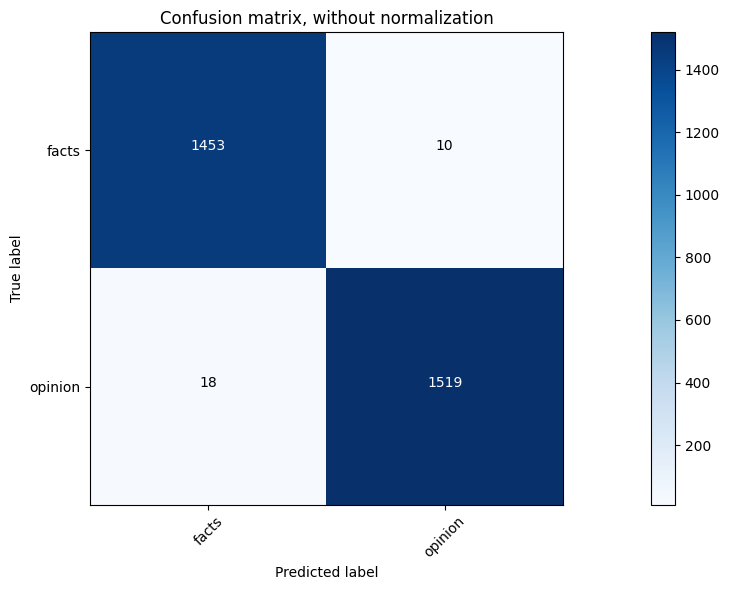

In [ ]:
model_09_pred = model_09.predict(test_padded_09)
y_pred_09 = []

for i in model_09_pred:
    if i >= 0.5:
        y_pred_09.append(1)
    else:
        y_pred_09.append(0)
        
# Check Model 09 Accuracy & Classification Report

accuracy_09 = accuracy_score(y_test,y_pred_09)
print("Accuracy of prediction on test set : ", accuracy_09)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_09))
f1score_09 = f1_score(y_test,y_pred_09)

# Plot Confusion Matrix
cnf_matrix_09 = confusion_matrix(y_test, y_pred_09)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_09, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# 32 + 12 + 1: 98.56 % Accuracy

### **Model 10 - Bi Directional LSTM 04**

* Vocab Size = 10000
* Embed_Dim = 50

In [ ]:
#total_words = set(X_train[['full_text_cleaned']].stack().str.split("[^\w+]").explode().tolist())

# Specify Vocabulary Size
#vocab_size = len(total_words)
vocab_size = 10000
print('Vocab Size: ', vocab_size)

# fixing every word's embedding size to be 50
#embd_len_10 = 50

#max_length = X_train['full_text_cleaned'].str.split().str.len().max()
#print('Max Length: ',max_length)

tokenizer_10 = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer_10.fit_on_texts(X_train['full_text_cleaned'])

Vocab Size:  10000


In [ ]:
train_sequences_10 = tokenizer_10.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_10 = pad_sequences(train_sequences_10, padding='pre', maxlen=max_length)

test_sequences_10 = tokenizer_10.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_10 = pad_sequences(test_sequences_10, padding='pre', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_10 = time.time()

import keras
model_10 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_10.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_10.summary()

model_10_history = model_10.fit(train_padded_10, y_train,epochs=5, verbose=1,validation_split=0.25)

# Stop Timer
stop_time_10 = time.time()
runtime_10 = stop_time_10 - start_time_10
print('\n')
print('Model 10 Procesing Time: ',runtime_10)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 1319, 100)         1000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 24)                3096      
                                                                 
 dense_19 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,087,601
Trainable params: 1,087,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
165/165 [==============================] - 50s 281ms/step - loss: 0.1598 - accuracy: 0.9335 - val_lo

94/94 [==============================] - 3s 28ms/step
Accuracy of prediction on test set :  0.992


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1463
           1       0.99      0.99      0.99      1537

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix, without normalization


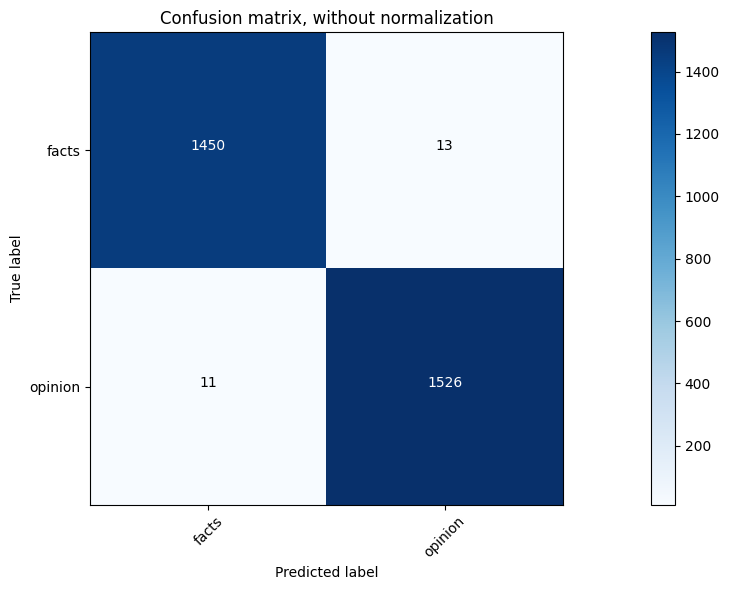

In [ ]:
model_10_pred = model_10.predict(test_padded_10)
y_pred_10 = []

for i in model_10_pred:
    if i >= 0.5:
        y_pred_10.append(1)
    else:
        y_pred_10.append(0)
        
# Check Model 02 Accuracy & Classification Report

accuracy_10 = accuracy_score(y_test,y_pred_10)
print("Accuracy of prediction on test set : ", accuracy_10)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_10))
f1score_10 = f1_score(y_test,y_pred_10)

# Plot Confusion Matrix
cnf_matrix_10 = confusion_matrix(y_test, y_pred_10)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_10, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Vocab Size = 20000: 98.76 % 
# Vocab Size = 10000: 98.86 %

### **Model 11 - Bi Directional LSTM 05**

* Bi Directional LSTM
* Pre Padding
* Vocab Size = 39258
* Embed Dim = 50
* Activation Function: linear

In [ ]:
train_sequences_11 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_11 = pad_sequences(train_sequences_11, padding='pre', maxlen=max_length)

test_sequences_11 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_11 = pad_sequences(test_sequences_11, padding='pre', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_11 = time.time()

import keras
model_11 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='linear'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_11.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_11.summary()

model_11_history = model_11.fit(train_padded_11, y_train,epochs=5, verbose=1,validation_split=0.25)

# Stop Timer
stop_time_11 = time.time()
runtime_11 = stop_time_11 - start_time_11
print('\n')
print('Model 11 Procesing Time: ',runtime_11)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 1319, 100)         1000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_20 (Dense)            (None, 24)                3096      
                                                                 
 dense_21 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,087,601
Trainable params: 1,087,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
165/165 [==============================] - 46s 256ms/step - loss: 0.1617 - accuracy: 0.9331 - val_lo

94/94 [==============================] - 3s 32ms/step
Accuracy of prediction on test set :  0.9926666666666667


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1463
           1       0.99      1.00      0.99      1537

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix, without normalization


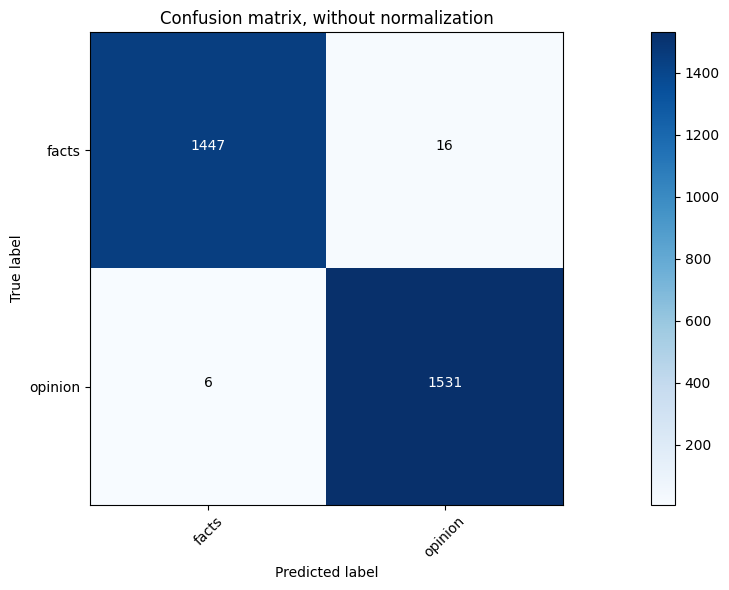

In [ ]:
model_11_pred = model_11.predict(test_padded_11)
y_pred_11 = []

for i in model_11_pred:
    if i >= 0.5:
        y_pred_11.append(1)
    else:
        y_pred_11.append(0)
        
# Check Model 02 Accuracy & Classification Report

accuracy_11 = accuracy_score(y_test,y_pred_11)
print("Accuracy of prediction on test set : ", accuracy_11)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_11))
f1score_11 = f1_score(y_test,y_pred_11)

# Plot Confusion Matrix
cnf_matrix_11 = confusion_matrix(y_test, y_pred_11)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_11, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

### **Model 12 - Bi Directional LSTM 06**

* Activation Function: tanh

In [ ]:
train_sequences_12 = tokenizer.texts_to_sequences(X_train['full_text_cleaned'])
train_padded_12 = pad_sequences(train_sequences_12, padding='pre', maxlen=max_length)

test_sequences_12 = tokenizer.texts_to_sequences(X_test['full_text_cleaned'])
test_padded_12 = pad_sequences(test_sequences_12, padding='pre', maxlen=max_length)

In [ ]:
# Start Timer
import time
start_time_12 = time.time()

import keras
model_12 = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='tanh'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_12.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_12.summary()

model_12_history = model_12.fit(train_padded_12, y_train,epochs=5, verbose=1,validation_split=0.25)

# Stop Timer
stop_time_12 = time.time()
runtime_12 = stop_time_12 - start_time_12
print('\n')
print('Model 12 Procesing Time: ',runtime_12)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 1319, 100)         1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_22 (Dense)            (None, 24)                3096      
                                                                 
 dense_23 (Dense)            (None, 1)                 25        
                                                                 
Total params: 1,087,601
Trainable params: 1,087,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
165/165 [==============================] - 42s 235ms/step - loss: 0.1892 - accuracy: 0.9270 - val_lo

94/94 [==============================] - 3s 29ms/step
Accuracy of prediction on test set :  0.9893333333333333


Classfication Report On Test Set:  
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1463
           1       0.99      0.99      0.99      1537

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix, without normalization


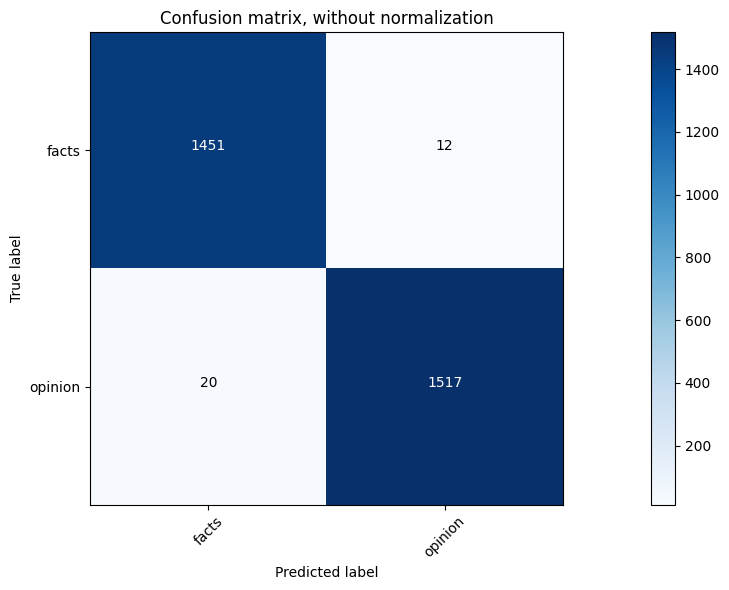

In [ ]:
model_12_pred = model_12.predict(test_padded_12)
y_pred_12 = []

for i in model_12_pred:
    if i >= 0.5:
        y_pred_12.append(1)
    else:
        y_pred_12.append(0)
        
# Check Model 02 Accuracy & Classification Report

accuracy_12 = accuracy_score(y_test,y_pred_12)
print("Accuracy of prediction on test set : ", accuracy_12)
print('\n')
print('Classfication Report On Test Set: ','\n',classification_report(y_test,y_pred_12))
f1score_12 = f1_score(y_test,y_pred_12)

# Plot Confusion Matrix
cnf_matrix_12 = confusion_matrix(y_test, y_pred_12)

plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_12, classes=target_names,title='Confusion matrix, without normalization')
plt.show()

## **Performance Benchmarking**

* Logistic Regression is a Non Neural Network based Model
* However, it achieves the highest accuracy score of 99.23 % while also managing to have a model training time of 0.7 second.
* The remarkable accuracy & computational efficiency makes this model noteworthy.
* It can be considered as the simplest classification algorithm which can be fully represented by in the form of a mathematical equation.
* Owing to it's simplicity, it is also the least computationally intensive.
* Considering that given training data has only 2 labels, Logistic Regression model would be the most suitable model.

**Logistic Regression Vs Neural Networks**

* However, considering a real world scenario where the model is expected to perform with a much larger vocabulary size & classify news articles into multiple labels like - Politics, Business, Science & Technology, Entertainment, Defence etc.
* A Neural Network based model is much more flexible if required to handle new categories. Vocabulary of these models can continuously updated with new articles if required without have to re run the entire model.

**External References**

https://jamesmccaffrey.wordpress.com/2018/07/07/why-a-neural-network-is-always-better-than-logistic-regression/ 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8942139/ 

### **Model 13 - Logistic Regression**

In [ ]:
# Start Timer
start_time_13 = time.time()

model_13 = LogisticRegression(random_state=0)
model_13.fit(vector_train,y_train)

accuracy_13 = model_13.score(vector_test, y_test)
print("Test Accuracy for Logistic Regression:",accuracy_13)
y_pred_13 = model_13.predict(vector_test)

# Stop Timer
stop_time_13 = time.time()
runtime_13 = stop_time_13 - start_time_13
print('\n')
print('Model 13 Procesing Time: ',runtime_13)

Test Accuracy for Logistic Regression: 0.9923333333333333


Model 13 Procesing Time:  1.3965697288513184


Accuracy of prediction on test set :  0.9923333333333333


              precision    recall  f1-score   support

       facts       1.00      0.99      0.99      1463
     opinion       0.99      1.00      0.99      1537

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion matrix, without normalization


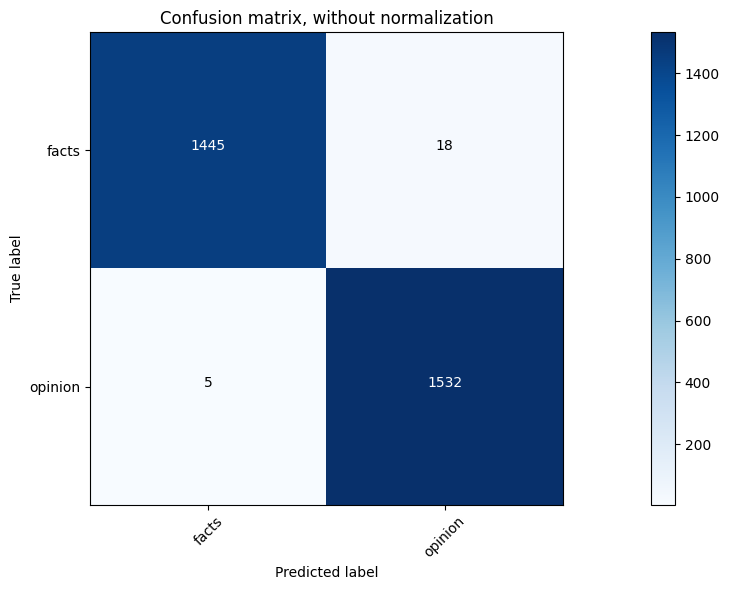

In [ ]:
# Accuracy
print("Accuracy of prediction on test set : ", accuracy_score(y_test,y_pred_13))
print('\n')

# Classification report
print(classification_report(y_test,y_pred_13, target_names=target_names))
f1score_13 = f1_score(y_test,y_pred_13)

# Confusion Matrix  
cnf_matrix_13 = confusion_matrix(y_test, y_pred_13)
plt.figure()
target_names =['facts','opinion']
plot_confusion_matrix(cnf_matrix_13, classes=target_names, title='Confusion matrix, without normalization')
plt.show()

# **Performance Comparison 01 - Primary**

* Model 01 - RNN With Pre Padding
* Model 02 - RNN With Post Padding
* Model 03 - GRU With Pre Padding
* Model 04 - GRU With Post Padding
* Model 05 - LSTM With Pre Padding
* Model 06 - LSTM With Post Padding
* Model 07 - Bi-Directional LSTM With Pre Padding
* Model 08 - Bi-Directional LSTM With Post Padding
* Model 13 - Logistic Regression

## **Accuracy Comparison 01**

Following plot compares the accuracy score achieved by all the 9 primary models

* Accuracy Of All Models reduces significantly when trained on Post Padded sequence.
* Performance of Bi-Directional LSTM model doesn't get affected with Post padded sequence.

In [ ]:
Model_List_01 = ['Model 01 - RNN Pre Pad', 'Model 02 - RNN Post Pad','Model 03 - GRU Pre Pad','Model 04 - GRU Post Pad','Model 05 - LSTM Pre Pad','Model 06 - LSTM Post Pad','Model 07 - BD LSTM Pre Pad','Model 08 - BD LSTM Post Pad','Model 13 - Log Regression']
Accuracy_List_01 = [accuracy_01,accuracy_02,accuracy_03,accuracy_04,accuracy_05,accuracy_06,accuracy_07,accuracy_08,accuracy_13]
F1_Score_01 = [f1score_01,f1score_02,f1score_03,f1score_04,f1score_05,f1score_06,f1score_07,f1score_08,f1score_13]

df_accuracy_01 = pd.DataFrame({'Model': Model_List_01,'Accuracy':Accuracy_List_01,'F1 Score':F1_Score_01})
df_accuracy_01

Model  Accuracy  F1 Score
0       Model 01 - RNN Pre Pad  0.983333  0.983829
1      Model 02 - RNN Post Pad  0.412333  0.216793
2       Model 03 - GRU Pre Pad  0.987667  0.987936
3      Model 04 - GRU Post Pad  0.487667  0.000000
4      Model 05 - LSTM Pre Pad  0.988667  0.988997
5     Model 06 - LSTM Post Pad  0.488000  0.001300
6   Model 07 - BD LSTM Pre Pad  0.988667  0.988968
7  Model 08 - BD LSTM Post Pad  0.974667  0.974934
8    Model 13 - Log Regression  0.992333  0.992549

<Axes: xlabel='Model'>

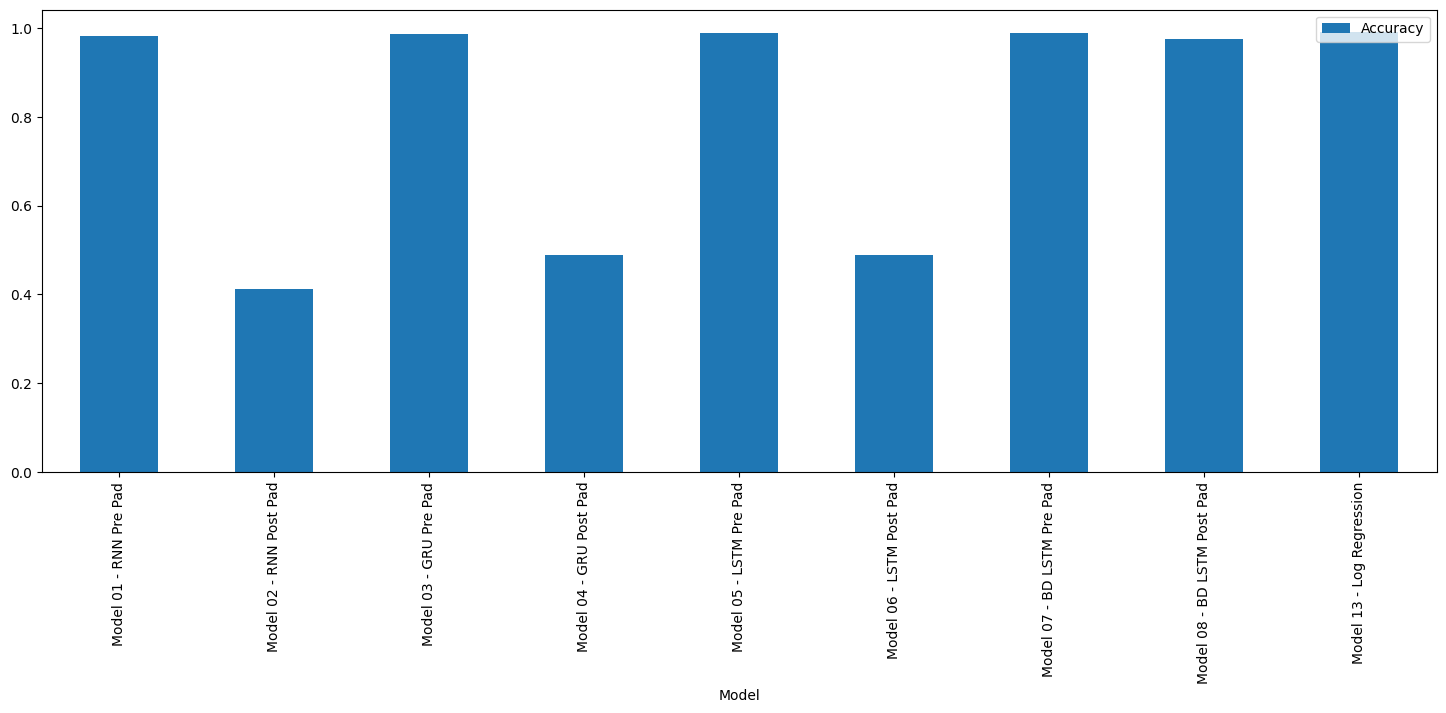

In [ ]:
df_accuracy_01.plot.bar(x='Model',y='Accuracy')

## **F1 Score Comparison 01**

<Axes: xlabel='Model'>

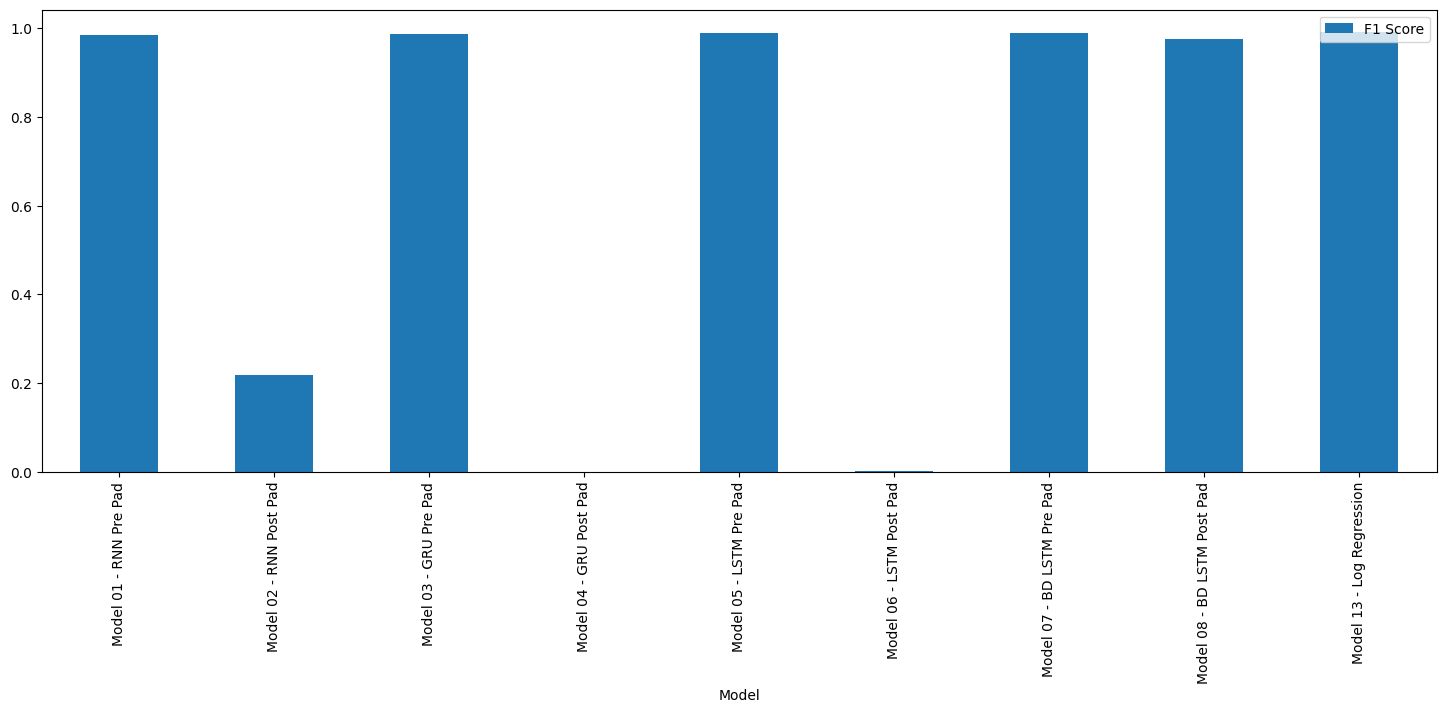

In [ ]:
df_accuracy_01.plot.bar(x='Model',y='F1 Score')

## **Computational Efficiency Plot 01**

This plot compares the computational efficiency of preliminary models (Model 01 - Model 08) based on their processing times. 

* RNN Model Has the highest training time
* GRU Model has the lowest training time
* LSTM Models have a significantly lower training time as compared to RNN
* Bi-Directional LSTM Models is just marginally longer than the standard LSTM Model. This noteworthy considering that it analyses the input data sequences in both forward & backward direction.
* Logistic Regression Model is the most efficient.

In [ ]:
Processing_Time_List_01 = [runtime_01,runtime_01,runtime_03,runtime_04,runtime_05,runtime_06,runtime_07,runtime_08,runtime_13]

df_runtime_01 = pd.DataFrame({'Model': Model_List_01,'Processing Time':Processing_Time_List_01})
df_runtime_01

Model  Processing Time
0       Model 01 - RNN Pre Pad       575.514729
1      Model 02 - RNN Post Pad       575.514729
2       Model 03 - GRU Pre Pad        85.877540
3      Model 04 - GRU Post Pad        79.586840
4      Model 05 - LSTM Pre Pad       146.071933
5     Model 06 - LSTM Post Pad       128.249501
6   Model 07 - BD LSTM Pre Pad       206.587748
7  Model 08 - BD LSTM Post Pad       205.551119
8    Model 13 - Log Regression         1.396570

<Axes: xlabel='Model'>

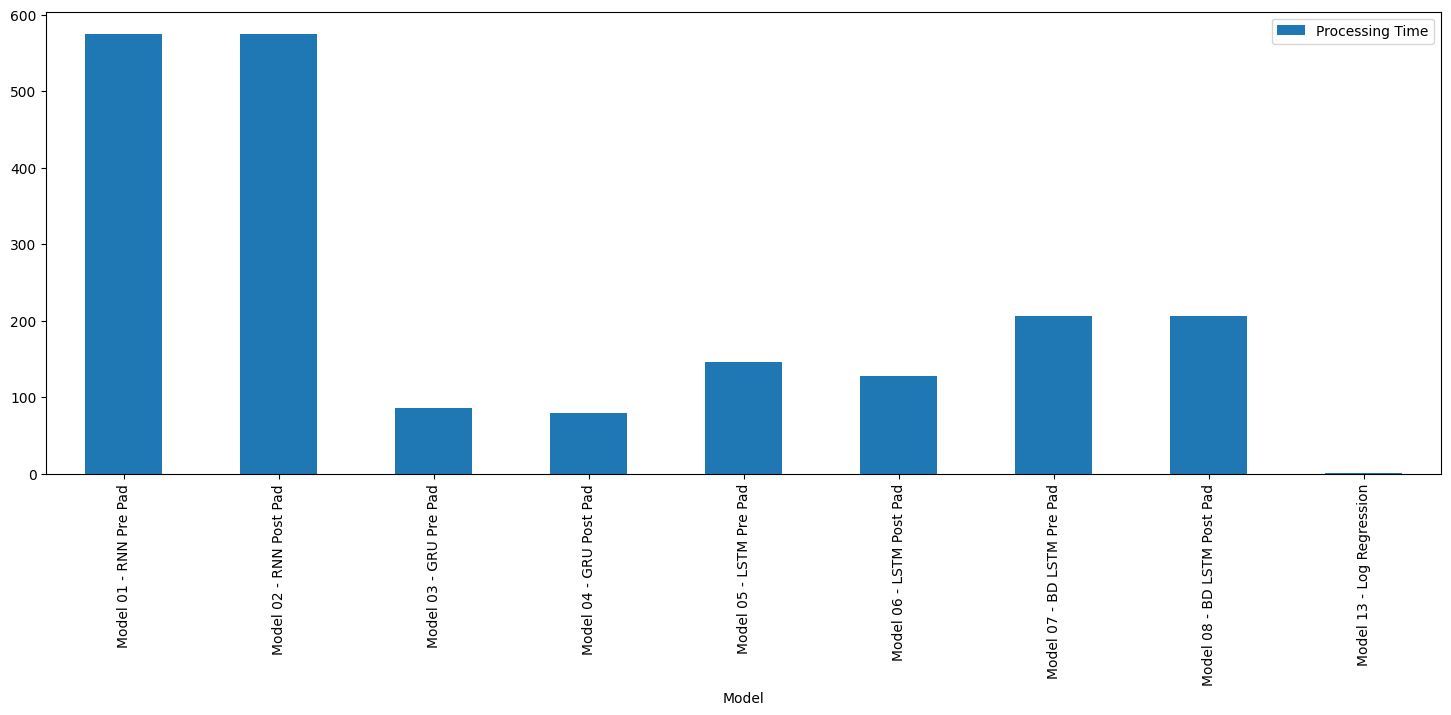

In [ ]:
df_runtime_01.plot.bar(x='Model',y='Processing Time')

## **Accuracy Vs Epoch Plot 01**

* As can be seen in the following graph, models with trained on Post Padded sequences have a significantly lower accuracy. This behaviour is observed for all Neural Network Models - RNN, GRU & LSTM (Model 01 - Model 06)
* A Bi-Directional LSTM Model is however able to handle this variation & shows no impact on its per accuracy. (Model 07 & Model 08)
* RNN Models take noticeable longer to achieve the best performance. * GRU, LSTM & BD LSTM all achieve the same the accuracy scores, but considering the computational efficiency, it would be better to use LSTM models as they achieve their best performance in just 1-2 epochs.

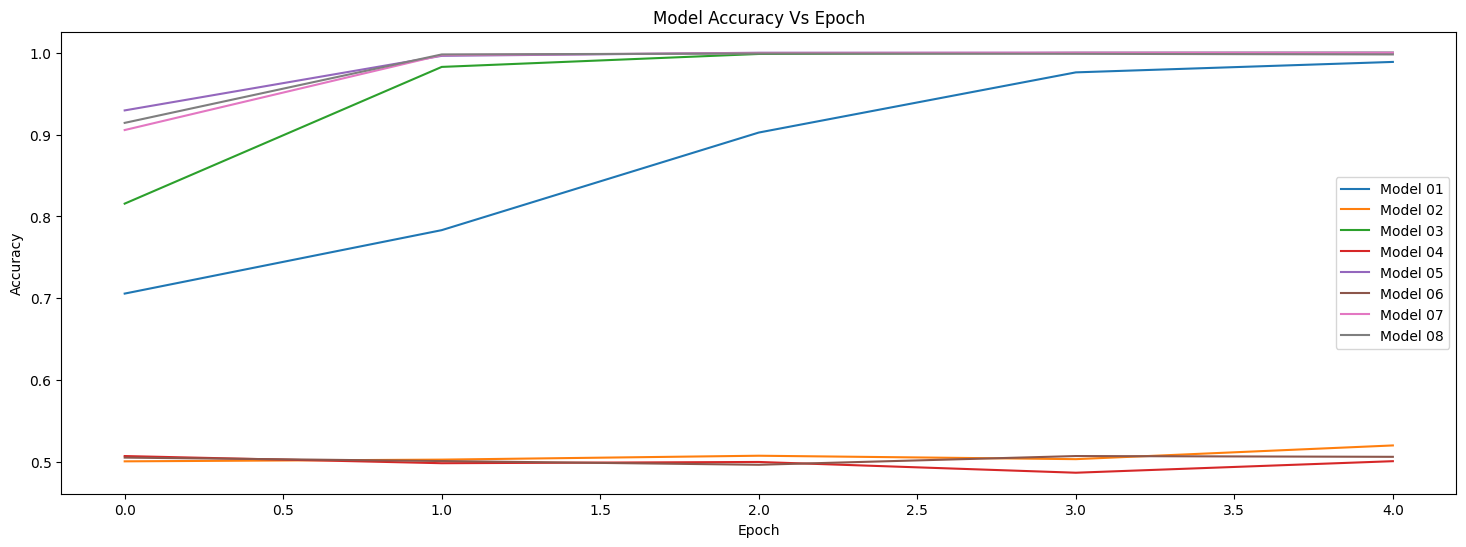

In [ ]:
# Visualise loss/accuracy during training

import matplotlib.pyplot as plt

plt.plot(model_01_history.history['accuracy'])
plt.plot(model_02_history.history['accuracy'])
plt.plot(model_03_history.history['accuracy'])
plt.plot(model_04_history.history['accuracy'])
plt.plot(model_05_history.history['accuracy'])
plt.plot(model_06_history.history['accuracy'])
plt.plot(model_07_history.history['accuracy'])
plt.plot(model_08_history.history['accuracy'])
plt.title('Model Accuracy Vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Model 01', 'Model 02','Model 03','Model 04','Model 05','Model 06','Model 07','Model 08'], loc='best')
plt.show()

## **Loss Vs Epoch Plot 01**

Following plot compares the loss values after each epoch for all the 8 primary models.

* Models trained on Post padded sequences struggle to optimize the loss values.
* Use Of Post Padded sequences has no effect on loss values of Bi-Directional LSTM Model.

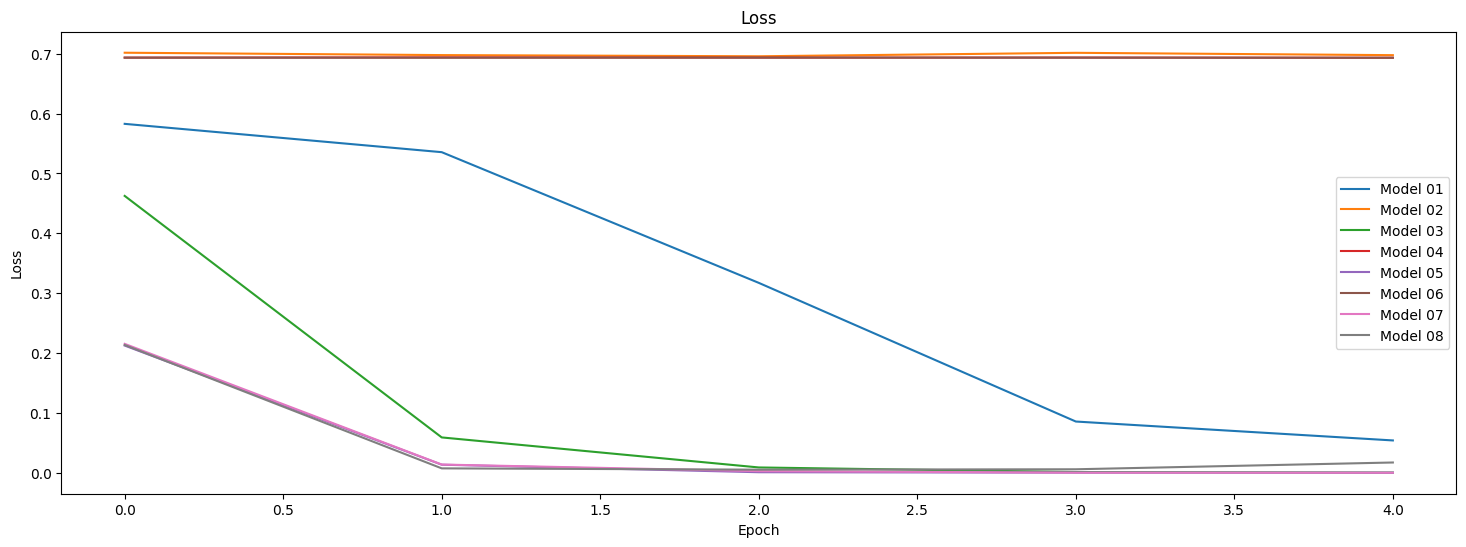

In [ ]:
plt.plot(model_01_history.history['loss'])
plt.plot(model_02_history.history['loss'])
plt.plot(model_03_history.history['loss'])
plt.plot(model_04_history.history['loss'])
plt.plot(model_05_history.history['loss'])
plt.plot(model_06_history.history['loss'])
plt.plot(model_07_history.history['loss'])
plt.plot(model_08_history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Model 01', 'Model 02','Model 03','Model 04','Model 05','Model 06','Model 07','Model 08'], loc='best')
plt.show()

## **ROC Curve Plot 01**

* All the models trained with post padded sequence have a lower AUC.
* AUC improves with the use of Pre padded sequences.
* In line with observations, pre & post padding has no effect on performance of Bi-Directional LSTM. 

In [ ]:
# Compute ROC curve and ROC area for each classifier

fpr_01, tpr_01, _ = roc_curve(y_test, model_01_pred[:, 0])
roc_auc_01 = auc(fpr_01, tpr_01)

fpr_02, tpr_02, _ = roc_curve(y_test, model_02_pred[:, 0])
roc_auc_02 = auc(fpr_02, tpr_02)

fpr_03, tpr_03, _ = roc_curve(y_test, model_03_pred[:, 0])
roc_auc_03 = auc(fpr_03, tpr_03)

fpr_04, tpr_04, _ = roc_curve(y_test, model_04_pred[:, 0])
roc_auc_04 = auc(fpr_04, tpr_04)

fpr_05, tpr_05, _ = roc_curve(y_test, model_05_pred[:, 0])
roc_auc_05 = auc(fpr_05, tpr_05)

fpr_06, tpr_06, _ = roc_curve(y_test, model_06_pred[:, 0])
roc_auc_06 = auc(fpr_06, tpr_06)

fpr_07, tpr_07, _ = roc_curve(y_test, model_07_pred[:, 0])
roc_auc_07 = auc(fpr_07, tpr_07)

fpr_08, tpr_08, _ = roc_curve(y_test, model_08_pred[:, 0])
roc_auc_08 = auc(fpr_08, tpr_08)

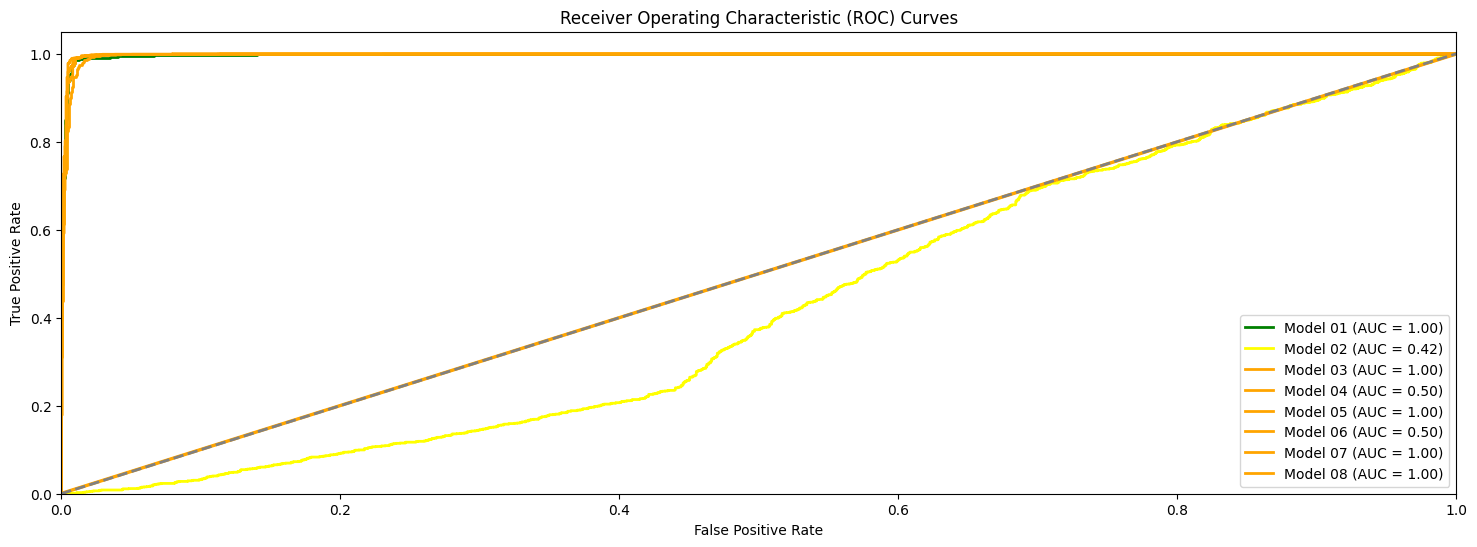

In [ ]:
# Plot the ROC curves

plt.figure()
plt.plot(fpr_01, tpr_01, color='green', lw=2, label='Model 01 (AUC = %0.2f)' % roc_auc_01)
plt.plot(fpr_02, tpr_02, color='yellow', lw=2, label='Model 02 (AUC = %0.2f)' % roc_auc_02)
plt.plot(fpr_03, tpr_03, color='orange', lw=2, label='Model 03 (AUC = %0.2f)' % roc_auc_03)
plt.plot(fpr_04, tpr_04, color='orange', lw=2, label='Model 04 (AUC = %0.2f)' % roc_auc_04)
plt.plot(fpr_05, tpr_05, color='orange', lw=2, label='Model 05 (AUC = %0.2f)' % roc_auc_05)
plt.plot(fpr_06, tpr_06, color='orange', lw=2, label='Model 06 (AUC = %0.2f)' % roc_auc_06)
plt.plot(fpr_07, tpr_07, color='orange', lw=2, label='Model 07 (AUC = %0.2f)' % roc_auc_07)
plt.plot(fpr_08, tpr_08, color='orange', lw=2, label='Model 08 (AUC = %0.2f)' % roc_auc_08)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# **Performance Comparison 02 - Secondary**

* Model 07 - Bi-Directional LSTM With Pre Padding
* Model 09 - BD LSTM With No Of Cells Reduces To Half
* Model 10 - BD LSTM Trained On Only 1/4 Vocabulary Size
* Model 11 - BD LSTM With Linear Activation Function
* Model 12 - BD LSTM With Tanh Activation Function

## **Accuracy Comparison 02**

In [ ]:
Model_List_02 = ['Model 07 - BD LSTM Pre Pad','Model 09 - BD LSTM Less Cells','Model 10 - BD LSTM Small Vocab','Model 11 - BD LSTM Linear AF','Model 12 - BD LSTM Tanh AF']
Accuracy_List_02 = [accuracy_07,accuracy_09,accuracy_10,accuracy_11,accuracy_12]
F1_Score_02 = [f1score_07,f1score_09,f1score_10,f1score_11,f1score_12]

df_accuracy_02 = pd.DataFrame({'Model': Model_List_02,'Accuracy':Accuracy_List_02,'F1 Score':F1_Score_02})
df_accuracy_02

Model  Accuracy  F1 Score
0      Model 07 - BD LSTM Pre Pad  0.988667  0.988968
1   Model 09 - BD LSTM Less Cells  0.990667  0.990868
2  Model 10 - BD LSTM Small Vocab  0.992000  0.992198
3    Model 11 - BD LSTM Linear AF  0.992667  0.992866
4      Model 12 - BD LSTM Tanh AF  0.989333  0.989563

<Axes: xlabel='Model'>

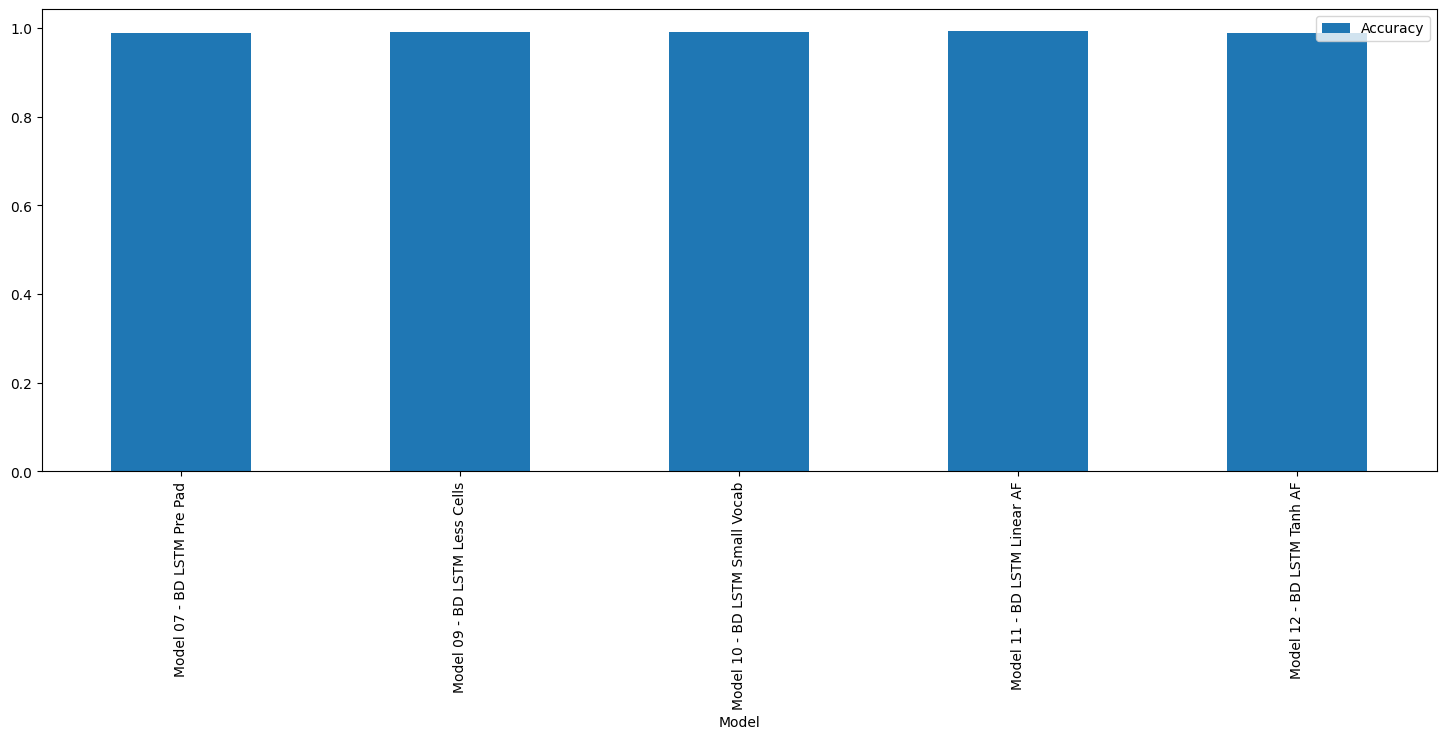

In [ ]:
df_accuracy_02.plot.bar(x='Model',y='Accuracy')

## **F1 Score Comparison Plot 02**

<Axes: xlabel='Model'>

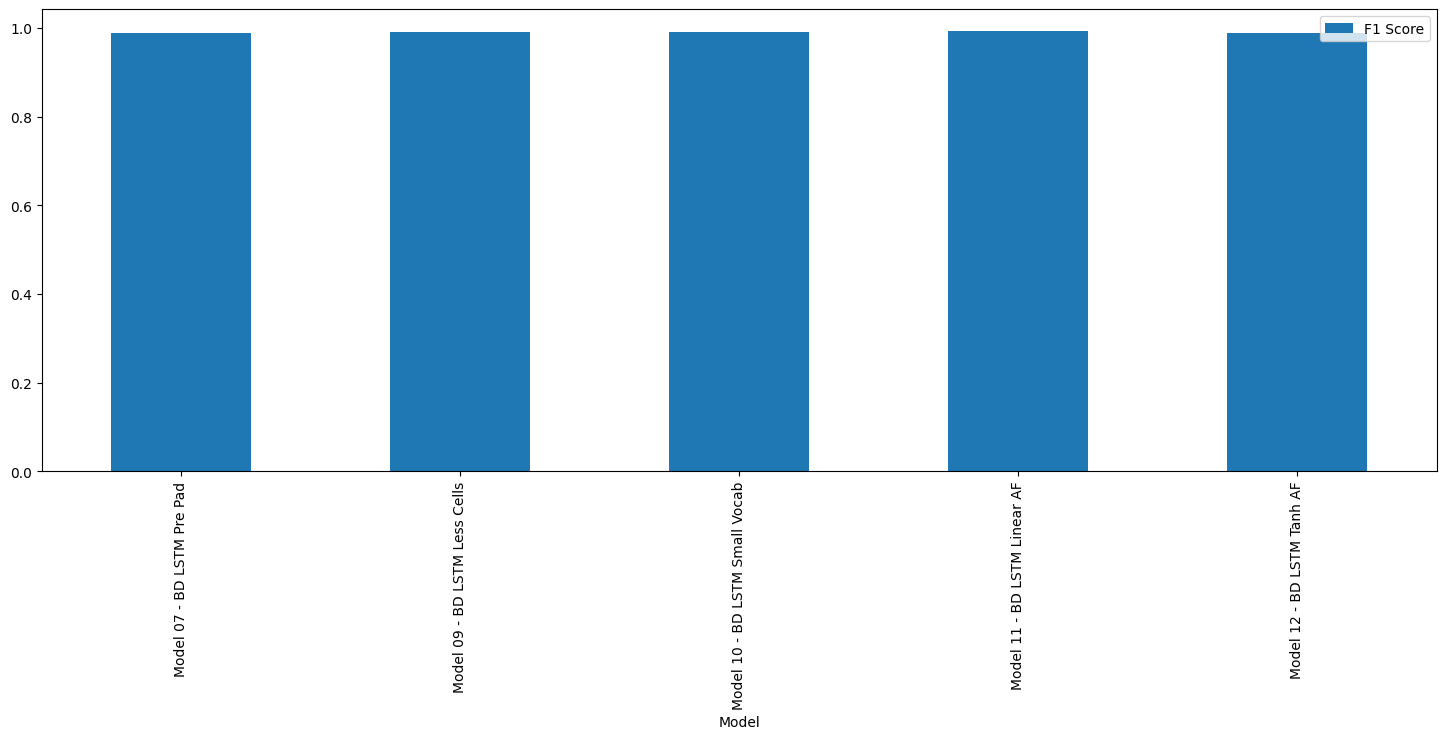

In [ ]:
df_accuracy_02.plot.bar(x='Model',y='F1 Score')

## **Computational Efficiency Plot 02**

This plot compares the relative effect of modifying various input parameters for the Bi-Directional LSTM Model trained on Pre padded sequences

* Model 09: Reducing the number of cells in each layer significantly reduces the processing time. Its worth noting that Model 09 has the lowest processing time among all the variants.
* Model 10: Using a limited vocabulary of just 1/4 size has no significant noticeable reduction in processing time.
* Model 11 & Model 12: Changing the activation function has significant effect on processing time.


In [ ]:
Processing_Time_List_02 = [runtime_07,runtime_09,runtime_10,runtime_11,runtime_12]

df_runtime_02 = pd.DataFrame({'Model': Model_List_02,'Processing Time':Processing_Time_List_02})
df_runtime_02

Model  Processing Time
0      Model 07 - BD LSTM Pre Pad       206.587748
1   Model 09 - BD LSTM Less Cells       123.182252
2  Model 10 - BD LSTM Small Vocab       171.446352
3    Model 11 - BD LSTM Linear AF       166.010561
4      Model 12 - BD LSTM Tanh AF       152.133783

<Axes: xlabel='Model'>

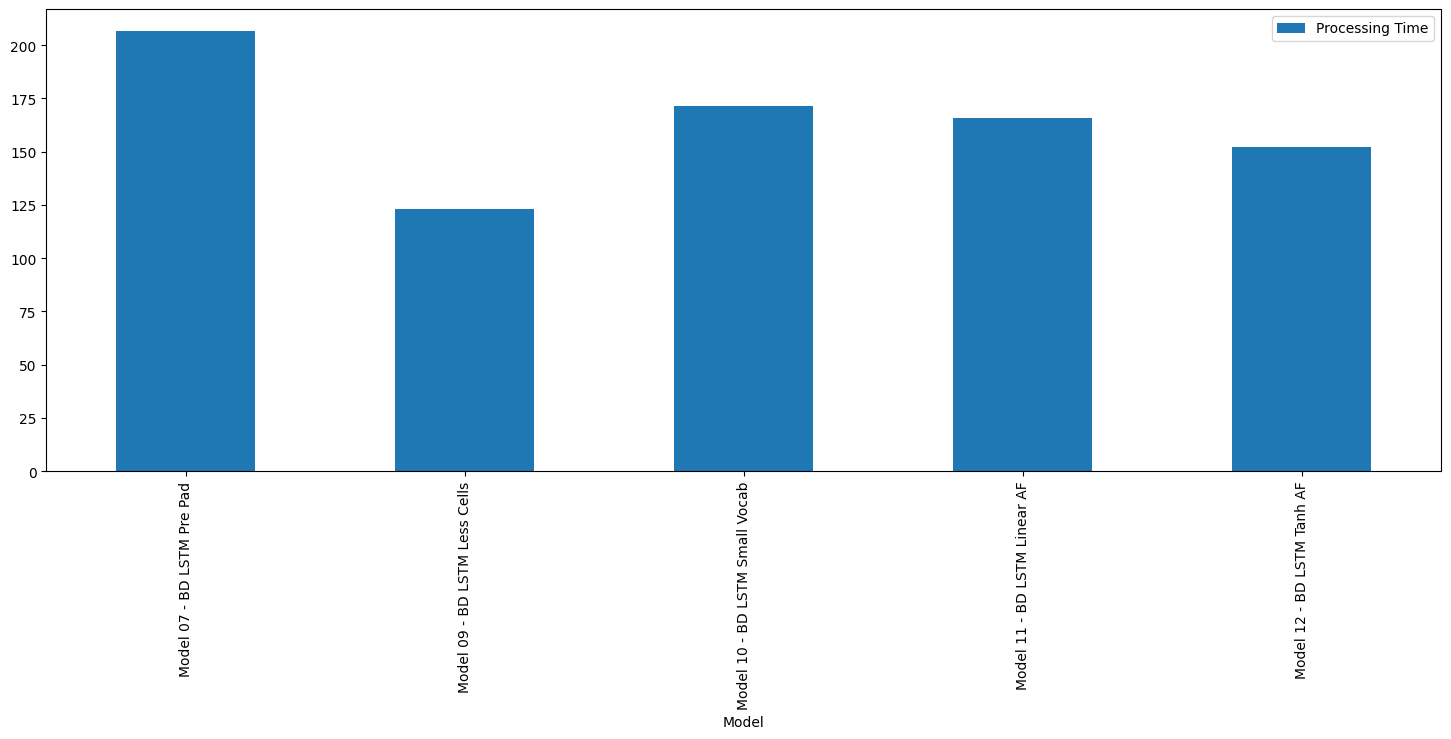

In [ ]:
df_runtime_02.plot.bar(x='Model',y='Processing Time')

## **Accuracy Vs Epoch Plot 02**

Following graph specifically compares the performance of BD LSTM Models with Pre Padded sequences with slight variation in their input parameters. The idea is to observer & fine tune the model for computational & time efficiency with an acceptable compromise on performance. Observations - 

* Model 09: Model 09 retains the same model settings as Model 07 except that number of cells in all layers have been halved. This has 

* Model 10: Model 10 starts off with a limited vocabulary size of just 10000 words. This is unlike the other models that are based on the full size vocabulary of ~ 40000 words. The model now struggles to improve the accuracy & needs ~ 3 epochs to match the performance of other models based on full size vocabulary.

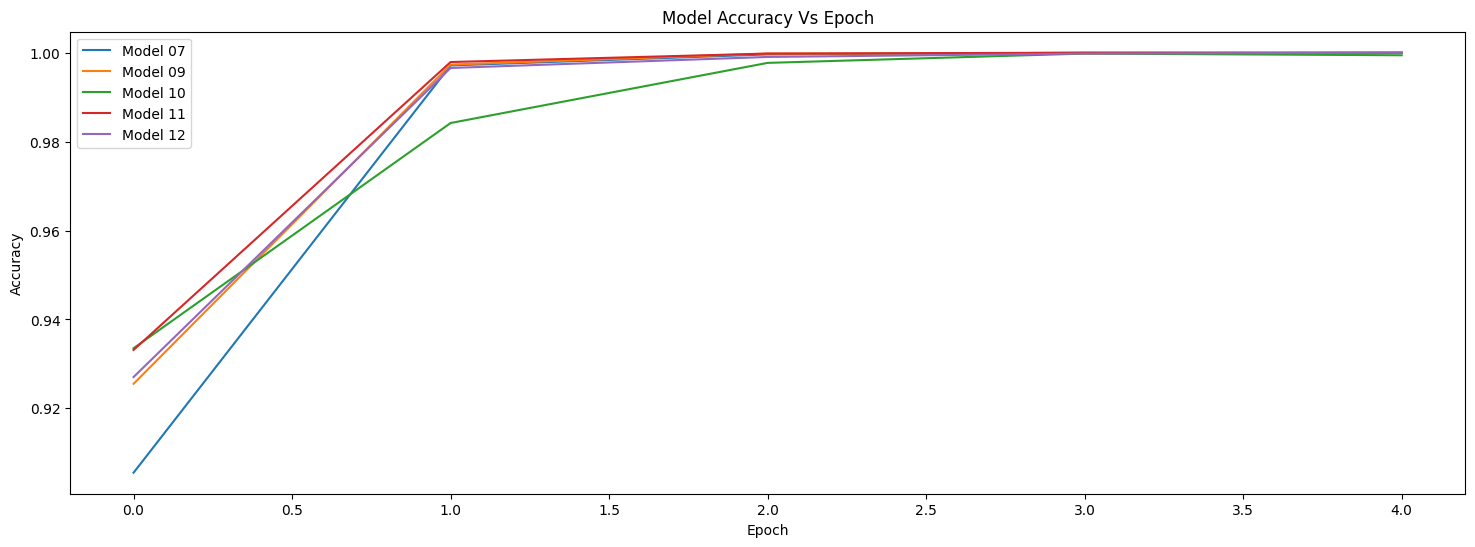

In [ ]:
# Visualise loss/accuracy during training

import matplotlib.pyplot as plt

plt.plot(model_07_history.history['accuracy'])
plt.plot(model_09_history.history['accuracy'])
plt.plot(model_10_history.history['accuracy'])
plt.plot(model_11_history.history['accuracy'])
plt.plot(model_12_history.history['accuracy'])
plt.title('Model Accuracy Vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Model 07','Model 09','Model 10','Model 11','Model 12'], loc='best')
plt.show()

## **Loss Vs Epoch Plot 02**

* Model 09: Though model 09 initially starts off with a higher loss value, it achieves the same loss value as Model 07 immediately after 1 epoch.
* Model 10: Its again evident that Model 10 struggles to minimize loss value with its limited vocabulary size.

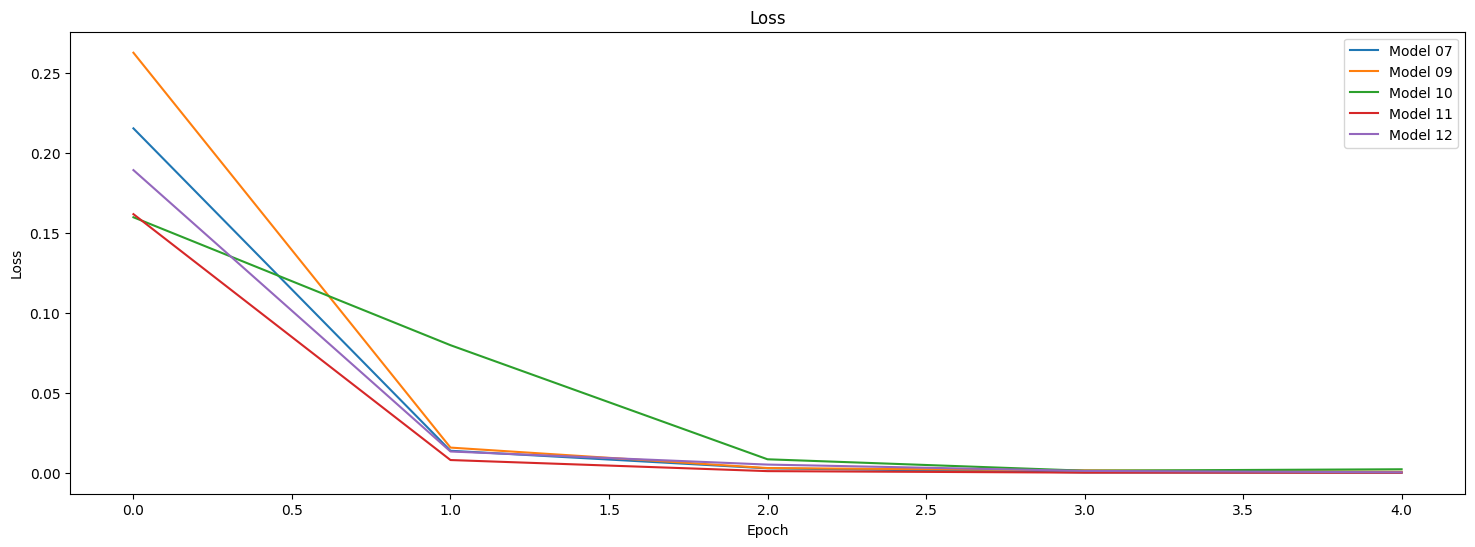

In [ ]:
plt.plot(model_07_history.history['loss'])
plt.plot(model_09_history.history['loss'])
plt.plot(model_10_history.history['loss'])
plt.plot(model_11_history.history['loss'])
plt.plot(model_12_history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Model 07','Model 09','Model 10','Model 11','Model 12'], loc='best')
plt.show()

## **ROC Curve Plot 02**

Following graph compares the ROC & AUC for different variants of Model 07 (BD LSTM With Pre Padding). Observations

* There is nothing noteworthy difference in ROC & AUC performance of Model 09 - Model 12 while comparing against Model 07.

In [ ]:
# Compute ROC curve and ROC area for each classifier

fpr_07, tpr_07, _ = roc_curve(y_test, model_07_pred[:, 0])
roc_auc_07 = auc(fpr_07, tpr_07)

fpr_09, tpr_09, _ = roc_curve(y_test, model_09_pred[:, 0])
roc_auc_09 = auc(fpr_09, tpr_09)

fpr_10, tpr_10, _ = roc_curve(y_test, model_10_pred[:, 0])
roc_auc_10 = auc(fpr_10, tpr_10)

fpr_11, tpr_11, _ = roc_curve(y_test, model_11_pred[:, 0])
roc_auc_11 = auc(fpr_11, tpr_11)

fpr_12, tpr_12, _ = roc_curve(y_test, model_12_pred[:, 0])
roc_auc_12 = auc(fpr_12, tpr_12)

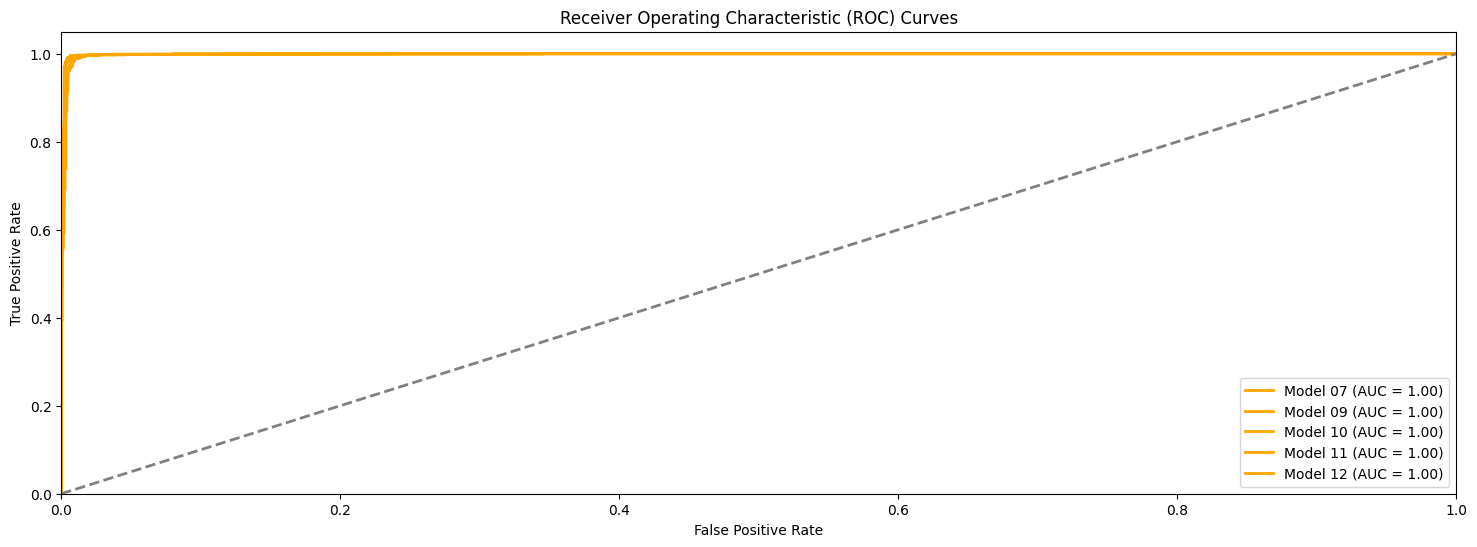

In [ ]:
# Plot the ROC curves

plt.figure()
plt.plot(fpr_07, tpr_07, color='orange', lw=2, label='Model 07 (AUC = %0.2f)' % roc_auc_07)
plt.plot(fpr_09, tpr_09, color='orange', lw=2, label='Model 09 (AUC = %0.2f)' % roc_auc_09)
plt.plot(fpr_10, tpr_10, color='orange', lw=2, label='Model 10 (AUC = %0.2f)' % roc_auc_10)
plt.plot(fpr_11, tpr_11, color='orange', lw=2, label='Model 11 (AUC = %0.2f)' % roc_auc_11)
plt.plot(fpr_12, tpr_12, color='orange', lw=2, label='Model 12 (AUC = %0.2f)' % roc_auc_12)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# **External References**

## **EDA**

In [ ]:
# https://www.analyticsvidhya.com/blog/2022/01/sentiment-analysis-with-lstm/

# https://www.geeksforgeeks.org/sentiment-analysis-with-an-recurrent-neural-networks-rnn/

## **Neural Network Models**

In [ ]:
# RNN


# LSTM 

# https://keras.io/api/layers/recurrent_layers/lstm 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM 


## **Performance Metrics**

In [ ]:
# https://en.wikipedia.org/wiki/Accuracy_and_precision

# https://en.wikipedia.org/wiki/Receiver_operating_characteristic

# https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc  